<a href="https://colab.research.google.com/github/frfusch21/DTS_GGU_5/blob/Hartantya-AT/quito_city_cab_ride_duration_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data** Ref 1

In [106]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, ElasticNet, Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from bayes_opt import BayesianOptimization

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# **Read Data** Ref 1

In [109]:
#uio = pd.read_csv('/content/drive/MyDrive/Belajar/all-data_clean.csv', header=0, sep=',', encoding="Latin1")
uio = pd.read_csv('/content/drive/MyDrive/Belajar/uio_clean.csv', header=0, sep=',', encoding="Latin1")
uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.503922,-0.232824,-78.549447,-0.361363,N,2025,24228,346
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.440306,0.006789,-78.490786,-0.104836,N,1390,16680,456
2,3,Quito,2016-09-16 06:29:36,2016-09-18 06:41:33,-78.469551,-0.143636,-78.470277,-0.131083,N,130317,1987,290
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.558076,-0.278241,-78.430220,-0.201934,N,1933,25146,302
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.521818,-0.208480,-78.504558,-0.222462,N,948,4625,314


Out of all the 4 datasets the data in file uio_clean.csv is for the Quito city. The data also has date-time information for pickup and drop off. These need to be converted to python date time format

In [110]:
uio['pickup_datetime'] = pd.to_datetime(uio['pickup_datetime'], format='%Y/%m/%d %H:%M:%S')
uio['dropoff_datetime'] = pd.to_datetime(uio['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

#checked a sample of file in notepad also to verify the datetime format. 

In [111]:
print(uio['pickup_datetime'].dt.time.max()) #There seems to be some data issue with this file as the pickup times are only between 01:00:01hours and 12:59:59 hours
print(uio['pickup_datetime'].dt.time.min())

12:59:59
01:00:01


In [112]:
uio.info()
#The datetime values are successfully converted

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32366 entries, 0 to 32365
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  32366 non-null  int64         
 1   vendor_id           32366 non-null  object        
 2   pickup_datetime     32366 non-null  datetime64[ns]
 3   dropoff_datetime    32366 non-null  datetime64[ns]
 4   pickup_longitude    32366 non-null  float64       
 5   pickup_latitude     32366 non-null  float64       
 6   dropoff_longitude   32366 non-null  float64       
 7   dropoff_latitude    32366 non-null  float64       
 8   store_and_fwd_flag  32366 non-null  object        
 9   trip_duration       32366 non-null  int64         
 10  dist_meters         32366 non-null  int64         
 11  wait_sec            32366 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(4), object(2)
memory usage: 3.0+ MB


In [113]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,32366.000000,32366.000000,32366.000000,32366.000000,32366.000000,3.236600e+04,3.236600e+04,3.236600e+04
mean,16183.500000,-78.492371,-0.189042,-78.492901,-0.191341,4.138239e+04,7.302745e+04,2.204058e+07
std,9343.403743,0.043108,0.076153,0.044783,0.085623,5.842226e+05,1.193671e+07,7.311736e+08
min,1.000000,-80.681697,-3.454279,-80.681721,-3.574739,-3.887110e+05,1.100000e+01,0.000000e+00
25%,8092.250000,-78.505867,-0.218344,-78.505734,-0.220508,5.000000e+02,2.148000e+03,1.070000e+02
50%,16183.500000,-78.490135,-0.181979,-78.490073,-0.185721,8.970000e+02,4.124000e+03,2.430000e+02
75%,24274.750000,-78.475783,-0.148715,-78.477443,-0.149867,1.710000e+03,7.475000e+03,4.990000e+02
max,32366.000000,-78.009669,0.866441,-77.710158,0.866759,7.002605e+07,2.147484e+09,9.516306e+10


**Observations from the above table:**
* no. of records = 32,366
* ID column is unique identified for each trip - this will not add any value with respect to the modeling work. So, it will need to be dropped.
* Columns that have outliers - pickup_latitude, drop_off_latitude, trip_duration, dist_meters, wait_sec. Their max values are unreasonably high eg. trip duration max value is ~596,523 hours, which cannot be true for any trip. These will require treatment.
* Minimum trip duration is negative, which is not possible in reality
* Minimum dist_meters is ~1.1m, which again is not any meaningful trip

# **Data Cleaning** Ref 1

**Initial Data Exploration**

In [114]:
uio['vendor_id'].unique()

array(['Quito', 'Quito Cabify Lite', 'Quito Cabify Executive',
       'Quito UberX'], dtype=object)

In [115]:
uio['store_and_fwd_flag'].unique() #store and forward flag has only one value - so it's not useful for modeling purpose

array(['N'], dtype=object)

In [116]:
np.percentile(uio['dropoff_latitude'], np.arange(0,101))

array([-3.57473934, -0.33398886, -0.32108551, -0.30925827, -0.30465401,
       -0.29943369, -0.29491717, -0.29083565, -0.2867376 , -0.28221929,
       -0.27820741, -0.27379464, -0.26969652, -0.26602729, -0.26205366,
       -0.25826332, -0.25438479, -0.25184421, -0.24902843, -0.24575843,
       -0.24253013, -0.23914544, -0.23424014, -0.22892724, -0.22392162,
       -0.22050754, -0.21830023, -0.21595555, -0.21383553, -0.21230584,
       -0.21055913, -0.20866416, -0.20746978, -0.20630101, -0.20524266,
       -0.20437713, -0.20324166, -0.20220993, -0.20103449, -0.19968433,
       -0.1984534 , -0.19719763, -0.19596371, -0.19455389, -0.19330854,
       -0.19196601, -0.19070446, -0.1893758 , -0.18837683, -0.18694791,
       -0.18572093, -0.18446377, -0.18351207, -0.18212339, -0.18089449,
       -0.17995989, -0.17874934, -0.17712845, -0.17623875, -0.17519255,
       -0.17368743, -0.17230462, -0.17089352, -0.16937256, -0.1679364 ,
       -0.16563786, -0.16413179, -0.16298403, -0.16239928, -0.16

In [117]:
np.percentile(uio['dropoff_longitude'], np.arange(0,101))

array([-80.68172095, -78.56186731, -78.55795514, -78.5546151 ,
       -78.55140158, -78.548503  , -78.54511691, -78.54256516,
       -78.54017986, -78.5373864 , -78.53467128, -78.53214094,
       -78.52935837, -78.52653615, -78.52370119, -78.52177438,
       -78.52006458, -78.51773791, -78.5156176 , -78.51355982,
       -78.5116725 , -78.51025128, -78.5089115 , -78.50769907,
       -78.50673879, -78.505734  , -78.50483696, -78.5041714 ,
       -78.5034568 , -78.5027615 , -78.50180022, -78.50092975,
       -78.50023634, -78.49961258, -78.49886279, -78.49830291,
       -78.49774102, -78.4972385 , -78.49661148, -78.49597623,
       -78.49537804, -78.49483709, -78.49424368, -78.49379155,
       -78.49326204, -78.49272275, -78.49213644, -78.4915624 ,
       -78.4910844 , -78.49060953, -78.49007314, -78.48949528,
       -78.4889018 , -78.48840619, -78.48796646, -78.48760571,
       -78.48719053, -78.48664261, -78.4860469 , -78.48562217,
       -78.48518585, -78.4847504 , -78.4842922 , -78.48

In [118]:
np.percentile(uio['pickup_latitude'], np.arange(0,101))

array([-3.45427926, -0.3279676 , -0.31457845, -0.30565066, -0.30047232,
       -0.29759637, -0.29122506, -0.28679532, -0.28208819, -0.27894855,
       -0.27561156, -0.27143656, -0.26823403, -0.26390717, -0.26023462,
       -0.25635074, -0.25299127, -0.25076124, -0.24805001, -0.24446868,
       -0.24132789, -0.2375631 , -0.23156556, -0.22497822, -0.22100434,
       -0.21834402, -0.2157231 , -0.21345674, -0.21155566, -0.20979412,
       -0.20801499, -0.20662379, -0.20521648, -0.20389533, -0.20248989,
       -0.2012631 , -0.19993601, -0.19863674, -0.19731877, -0.19621258,
       -0.1949322 , -0.19362547, -0.19241569, -0.19092075, -0.1893911 ,
       -0.18831635, -0.18688197, -0.18544805, -0.18405203, -0.18284984,
       -0.18197948, -0.18118765, -0.18056326, -0.18032262, -0.17890435,
       -0.17724511, -0.17685307, -0.1760617 , -0.17482229, -0.17261259,
       -0.1707287 , -0.16895395, -0.16654265, -0.16439234, -0.16376827,
       -0.16304404, -0.16261359, -0.16220723, -0.16065614, -0.15

In [119]:
np.percentile(uio['pickup_longitude'], np.arange(0,101))

array([-80.68169668, -78.56111853, -78.55704696, -78.55293367,
       -78.54967373, -78.54630114, -78.54300461, -78.53992132,
       -78.53711043, -78.53448828, -78.53189414, -78.5294755 ,
       -78.52728537, -78.52466573, -78.52255546, -78.52110272,
       -78.51908176, -78.51660744, -78.51467603, -78.51260914,
       -78.51089759, -78.5096599 , -78.50842618, -78.50733708,
       -78.50660399, -78.50586728, -78.50518183, -78.50490995,
       -78.50480524, -78.50433921, -78.50362421, -78.50299059,
       -78.50221773, -78.50132681, -78.50046397, -78.4997787 ,
       -78.49916137, -78.49864868, -78.49804539, -78.49747834,
       -78.49684459, -78.49619051, -78.49548047, -78.49476517,
       -78.4940299 , -78.49347741, -78.49288485, -78.49213122,
       -78.49139751, -78.49076666, -78.49013523, -78.48934773,
       -78.48861298, -78.48793196, -78.48731909, -78.48680859,
       -78.48610587, -78.48563489, -78.48506826, -78.48447735,
       -78.48389441, -78.48332658, -78.48291353, -78.48

In [120]:
#uio = uio[(uio['dropoff_latitude'] >= -0.32628809) & (uio['dropoff_latitude'] <= -0.07806344)]   #remove the outliers from dropoff latitude
#uio.shape

In [121]:
#uio = uio[(uio['pickup_latitude'] >= -0.32628809) & (uio['pickup_latitude'] <= -0.07806344)]   #remove the outliers from pickup latitude
#uio.shape


In [122]:
np.percentile(uio['dist_meters']/1000, np.arange(90,101)) #percentile distribution of trip distance in km. Based on this the upper limit
#for ditastance is chosen as  50km

array([1.31250000e+01, 1.38911500e+01, 1.48346000e+01, 1.59650000e+01,
       1.72823000e+01, 1.87310000e+01, 2.11728000e+01, 2.44233500e+01,
       2.94845000e+01, 4.03255000e+01, 2.14748365e+06])

In [123]:
uio['dist_meters'] = uio['dist_meters']/1000
uio = uio[uio['dist_meters'] <= 50]  
uio.shape

(32167, 12)

In [124]:
np.percentile(uio['dist_meters'], np.arange(0,101))   #veriy the values of destance meters in km

array([1.100000e-02, 2.800000e-02, 4.500000e-02, 7.000000e-02,
       1.056400e-01, 1.620000e-01, 2.460000e-01, 3.520000e-01,
       4.702800e-01, 6.050000e-01, 7.426000e-01, 8.632600e-01,
       9.930000e-01, 1.114000e+00, 1.213000e+00, 1.313000e+00,
       1.403000e+00, 1.493000e+00, 1.579000e+00, 1.667540e+00,
       1.748000e+00, 1.831000e+00, 1.916000e+00, 1.984000e+00,
       2.059000e+00, 2.136000e+00, 2.216160e+00, 2.289000e+00,
       2.365000e+00, 2.443000e+00, 2.519000e+00, 2.592000e+00,
       2.668000e+00, 2.737000e+00, 2.807000e+00, 2.882100e+00,
       2.956000e+00, 3.039000e+00, 3.115080e+00, 3.196740e+00,
       3.281000e+00, 3.357000e+00, 3.433000e+00, 3.515380e+00,
       3.598000e+00, 3.679000e+00, 3.764000e+00, 3.843000e+00,
       3.920000e+00, 4.011340e+00, 4.092000e+00, 4.188000e+00,
       4.283000e+00, 4.372980e+00, 4.463640e+00, 4.561000e+00,
       4.660000e+00, 4.766000e+00, 4.870000e+00, 4.970000e+00,
       5.095000e+00, 5.215000e+00, 5.332920e+00, 5.4465

In [125]:
np.percentile(uio['trip_duration']/60, np.arange(0,101))

array([-6.47851667e+03,  3.83333333e-01,  6.50000000e-01,  9.66666667e-01,
        1.38333333e+00,  1.83333333e+00,  2.35000000e+00,  2.85000000e+00,
        3.30000000e+00,  3.74900000e+00,  4.13333333e+00,  4.50000000e+00,
        4.81666667e+00,  5.16666667e+00,  5.48333333e+00,  5.75000000e+00,
        6.01666667e+00,  6.28333333e+00,  6.53333333e+00,  6.80000000e+00,
        7.08333333e+00,  7.33333333e+00,  7.56666667e+00,  7.83333333e+00,
        8.06666667e+00,  8.30000000e+00,  8.53333333e+00,  8.76666667e+00,
        9.00000000e+00,  9.21666667e+00,  9.45000000e+00,  9.70000000e+00,
        9.93333333e+00,  1.01666667e+01,  1.04000000e+01,  1.06333333e+01,
        1.09000000e+01,  1.11570000e+01,  1.14000000e+01,  1.16833333e+01,
        1.19333333e+01,  1.22000000e+01,  1.24833333e+01,  1.27500000e+01,
        1.30333333e+01,  1.33333333e+01,  1.36333333e+01,  1.39166667e+01,
        1.42166667e+01,  1.45333333e+01,  1.48333333e+01,  1.52000000e+01,
        1.55333333e+01,  

In [126]:
uio['trip_duration'] =  uio['trip_duration']/60
uio = uio[(uio['trip_duration'] >= 0.5) & (uio['trip_duration'] <=350. )] #trip duration must be between 1 min and 350 minutes
uio.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(29616, 12)

In [127]:
np.percentile(uio['trip_duration'], np.arange(0,101))   #veriy the values of trip duration in minutes

array([  0.5       ,   0.7525    ,   1.08333333,   1.48333333,
         1.9       ,   2.4       ,   2.85      ,   3.26666667,
         3.66666667,   4.05      ,   4.4       ,   4.7       ,
         5.01666667,   5.31666667,   5.58333333,   5.81666667,
         6.08333333,   6.31666667,   6.55      ,   6.8       ,
         7.05      ,   7.28333333,   7.5       ,   7.73333333,
         7.96666667,   8.16666667,   8.38333333,   8.61666667,
         8.81666667,   9.03333333,   9.25      ,   9.45      ,
         9.68333333,   9.9       ,  10.11666667,  10.31666667,
        10.55      ,  10.78333333,  11.01666667,  11.25      ,
        11.48333333,  11.73333333,  11.95      ,  12.21666667,
        12.46666667,  12.73333333,  12.98333333,  13.25      ,
        13.53333333,  13.81666667,  14.06666667,  14.35      ,
        14.65      ,  14.93333333,  15.26666667,  15.56666667,
        15.86666667,  16.21666667,  16.55      ,  16.91666667,
        17.23333333,  17.58333333,  17.95      ,  18.31

In [128]:

np.percentile(uio['wait_sec']/60, np.arange(0,101))  #distrubution of waiting time in minutes. 
#Based on this we will drop any records with more than 100 munutes of waiting tmie

array([0.00000000e+00, 5.00000000e-02, 1.50000000e-01, 2.50000000e-01,
       3.33333333e-01, 4.16666667e-01, 5.00000000e-01, 5.66666667e-01,
       6.50000000e-01, 7.33333333e-01, 8.00000000e-01, 8.83333333e-01,
       9.50000000e-01, 1.01666667e+00, 1.08333333e+00, 1.16666667e+00,
       1.21666667e+00, 1.30000000e+00, 1.35000000e+00, 1.43333333e+00,
       1.50000000e+00, 1.56666667e+00, 1.63333333e+00, 1.70000000e+00,
       1.76666667e+00, 1.85000000e+00, 1.91666667e+00, 2.00000000e+00,
       2.06666667e+00, 2.13916667e+00, 2.21666667e+00, 2.30000000e+00,
       2.38333333e+00, 2.45000000e+00, 2.53333333e+00, 2.60000000e+00,
       2.70000000e+00, 2.78333333e+00, 2.86666667e+00, 2.96666667e+00,
       3.05000000e+00, 3.13333333e+00, 3.23333333e+00, 3.31666667e+00,
       3.41666667e+00, 3.51666667e+00, 3.61666667e+00, 3.71666667e+00,
       3.81666667e+00, 3.91666667e+00, 4.03333333e+00, 4.13333333e+00,
       4.25000000e+00, 4.36666667e+00, 4.48333333e+00, 4.58333333e+00,
      

In [129]:
uio['wait_sec'] = uio['wait_sec']/60
uio = uio[uio['wait_sec'] <= 100]
uio.shape

(29126, 12)

In [130]:
uio[uio['trip_duration'] <= uio['wait_sec']].count() #Trip duration should not be less than waiting time

id                    364
vendor_id             364
pickup_datetime       364
dropoff_datetime      364
pickup_longitude      364
pickup_latitude       364
dropoff_longitude     364
dropoff_latitude      364
store_and_fwd_flag    364
trip_duration         364
dist_meters           364
wait_sec              364
dtype: int64

In [131]:
uio =uio[uio['trip_duration'] > uio['wait_sec']]
uio.shape

(28762, 12)

In [132]:
uio[uio['trip_duration'] <= uio['wait_sec']].count()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

In [133]:
np.percentile(uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60, np.arange(0,101))
# There are some records with more than 2 minutes difference - these will need to be removed

array([-7.20000000e+02, -7.20000000e+02, -7.19983333e+02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.66666667e-02,  

In [134]:
uio = uio[np.abs(uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60) <= 2]
uio.shape

(28023, 12)

In [135]:
np.percentile((uio['trip_duration']- (uio['dropoff_datetime'] - uio['pickup_datetime']).dt.seconds/60), np.arange(0,101)) 
#verify the distribution of difference between trip duration and drop offf - pickup date times

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666667,
       0.01666667, 0.01666667, 0.01666667, 0.01666667, 0.01666

In [136]:
uio.isna().sum()  #check if any NaN / nulls present

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dist_meters           0
wait_sec              0
dtype: int64

#**Data Visualization** Ref 1

In [137]:
#In the absence of any information about how data is captured for pickup and drop off datetime and trip duration, 
#we can't make any assumption regarding which one is more accurate. So, dropping records where the time difference 
#is more than 2 minute. We are using 2 minutes here based on the percentile distribution shown in previous section 
#for this metric

In [138]:
uio.shape

(28023, 12)

In [139]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
count,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000
mean,16204.706420,-78.491650,-0.188046,-78.492094,-0.189666,20.681937,5.630726,6.406819
std,9331.393756,0.033034,0.065007,0.033457,0.066221,25.648180,5.576272,9.020875
min,1.000000,-79.933237,-2.875814,-79.933136,-2.875482,0.500000,0.020000,0.000000
25%,8171.500000,-78.505541,-0.216703,-78.504907,-0.218701,8.183333,2.247000,1.783333
50%,16211.000000,-78.489876,-0.181872,-78.489870,-0.185550,13.900000,4.070000,3.866667
75%,24295.500000,-78.475472,-0.149750,-78.477444,-0.151312,23.600000,7.072000,7.433333
max,32366.000000,-78.132979,0.866441,-78.133230,0.866759,349.683333,49.581000,99.933333


**Data Visualization**

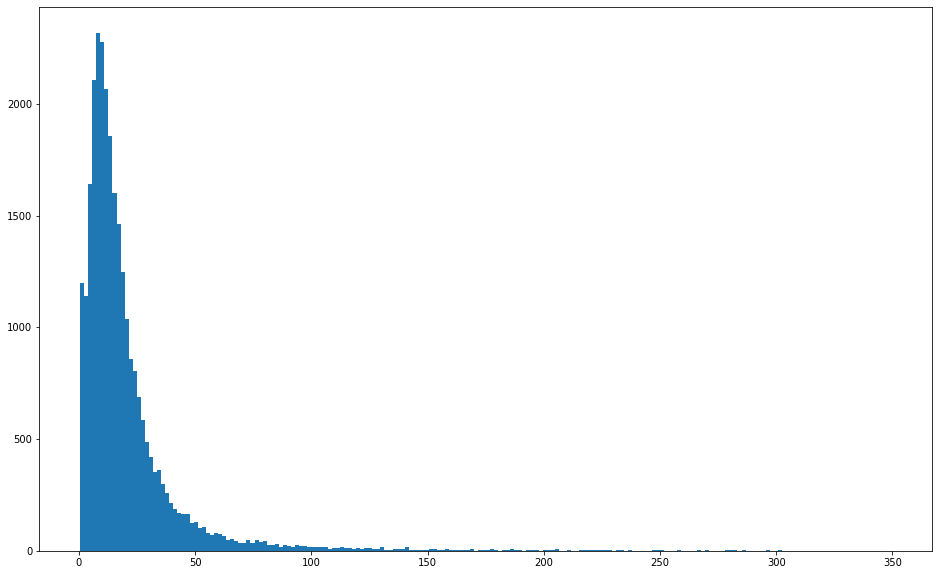

In [140]:
plt.hist(uio['trip_duration'].values, bins=200)
plt.show()

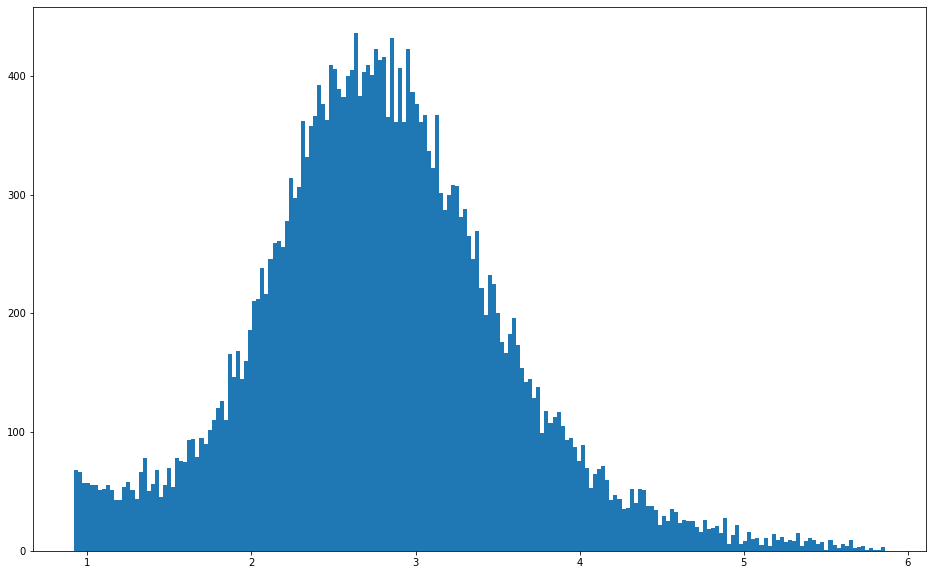

In [141]:
plt.hist(np.log1p(uio['trip_duration'].values + 1), bins=200)
plt.show()

In [143]:
vendor_freq = uio.groupby(['vendor_id'])['id'].count().reset_index()
vendor_freq

,vendor_id,id
0,Quito,27631
1,Quito Cabify Executive,60
2,Quito Cabify Lite,330
3,Quito UberX,2


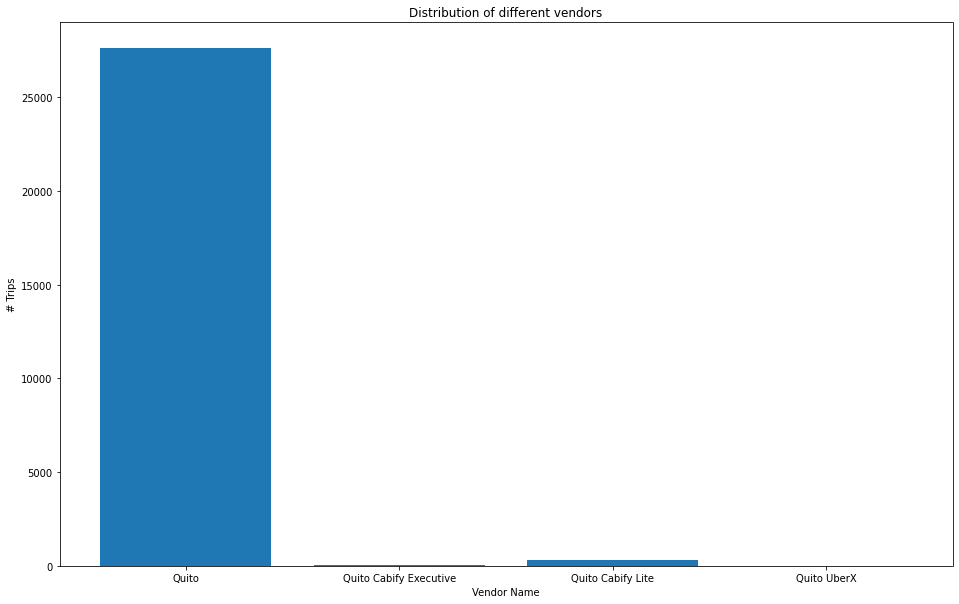

In [144]:
plt.bar(x=vendor_freq['vendor_id'], height=vendor_freq['id'])
plt.title("Distribution of different vendors")
plt.xlabel("Vendor Name")
plt.ylabel("# Trips")
plt.show()

# **Feature Engineering** Ref 1

In [145]:
def ride_length_group(distance):
    distance = distance 
    if distance <= 5 : grp = 1
    elif distance <= 10 : grp = 2
    elif distance <=15 : grp = 3
    elif distance <=20 : grp = 4
    elif distance <=25 : grp = 5
    elif distance <=30 : grp = 6
    elif distance <=35 : grp= 7
    elif distance <=40: grp= 8
    elif distance <=45: grp= 9
    else : grp=10
    return grp

def minute_group(minute):
    if minute <= 15 : grp = 1
    elif minute <= 30 : grp = 2
    elif minute <=45 : grp = 3
    else : grp=4
    return grp

In [146]:
uio['ride_length_grp'] = uio['dist_meters'].apply(ride_length_group)

In [147]:
uio['ride_month'] = uio['pickup_datetime'].dt.month
uio['ride_year'] = uio['pickup_datetime'].dt.year
uio['ride_day'] = uio['pickup_datetime'].dt.day
uio['ride_hour'] = uio['pickup_datetime'].dt.hour
uio['ride_minute'] = uio['pickup_datetime'].dt.minute
uio['day_of_week'] = uio['pickup_datetime'].dt.dayofweek

uio['season'] = uio['ride_month'].apply(lambda x: 1 if x >= 6 and x <= 9 else 0) #Quito has two seasons only as per https://en.wikipedia.org/wiki/Climate_of_Ecuador
# Since Quito lies on equator, there is not much difference in daylight duration across the year

uio['vendor_flg'] = uio['vendor_id'].apply(lambda x: 1 if x.lower()=='quito' else 0)
uio['minute_grp'] = uio['ride_minute'].apply(minute_group)

uio['diff_longitude'] = np.round(uio['dropoff_longitude'] - uio['pickup_longitude'], decimals=4)
uio['diff_latitude'] = np.round(uio['dropoff_latitude'] - uio['pickup_latitude'], decimals=4)
uio.head()


# https://www.officeholidays.com/countries/ecuador/2017.php - holidays list of Ecuador
holidays = ['2016-01-01', '2016-02-08', '2016-02-09', '2016-03-25', '2016-03-27', 
            '2016-05-01', '2016-05-27', '2016-07-24', '2016-08-10', '2016-10-09', 
            '2016-11-02', '2016-11-03', '2016-12-06', '2016-12-25', 
            '2017-01-01', '2017-02-27', '2017-02-28', '2017-04-14', '2017-04-16', 
            '2017-05-01', '2017-05-24', '2017-07-24', '2017-08-10', '2017-10-09', 
            '2017-11-02', '2017-11-03', '2017-12-06', '2017-12-25']
holidays = pd.to_datetime(holidays)
# was the day a public holiday?


uio['holiday'] = 1*(pd.to_datetime(uio['pickup_datetime'].dt.date).isin(holidays))

uio['pickup_latitude'] = np.round(uio['pickup_latitude'], decimals =4)
uio['dropoff_latitude'] = np.round(uio['dropoff_latitude'], decimals =4)
uio['pickup_longitude'] = np.round(uio['pickup_longitude'], decimals =4)
uio['dropoff_longitude'] = np.round(uio['dropoff_longitude'], decimals =4)

uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,ride_day,ride_hour,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.5039,-0.2328,-78.5494,-0.3614,N,33.750000,...,17,9,32,5,1,1,3,-0.0455,-0.1285,0
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.4403,0.0068,-78.4908,-0.1048,N,23.166667,...,18,4,3,6,1,1,1,-0.0505,-0.1116,0
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.5581,-0.2782,-78.4302,-0.2019,N,32.216667,...,18,5,57,6,1,1,4,0.1279,0.0763,0
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.5218,-0.2085,-78.5046,-0.2225,N,15.800000,...,18,7,58,6,1,1,4,0.0173,-0.0140,0
5,6,Quito,2016-08-27 04:19:02,2016-08-27 04:44:12,-78.5092,-0.1948,-78.5188,-0.2288,N,25.166667,...,27,4,19,5,1,1,2,-0.0096,-0.0340,0


# **Feature Engineering Lanjutan**  Ref 1 - SKIP

In [148]:
uio['trip_duration_log'] = np.log1p(uio['trip_duration'] + 1)
#wait_sec and dropoff_time should not be used for prediction as that can cause leakage

uio['average_speed'] = uio['dist_meters'] / (uio['trip_duration']/60)    # in km per hour

In [149]:
np.percentile(uio['average_speed'], np.arange(0,101))

array([7.44021258e-03, 5.21602813e-01, 1.15470103e+00, 1.80000000e+00,
       2.57374800e+00, 3.38129547e+00, 4.20130886e+00, 4.96375771e+00,
       5.64502946e+00, 6.31144387e+00, 7.01943453e+00, 7.73964892e+00,
       8.33015078e+00, 8.78802970e+00, 9.26344896e+00, 9.72037199e+00,
       1.01555573e+01, 1.05543411e+01, 1.08812248e+01, 1.11847536e+01,
       1.15117100e+01, 1.18294218e+01, 1.21260996e+01, 1.24189804e+01,
       1.27030190e+01, 1.29399966e+01, 1.32016333e+01, 1.34549553e+01,
       1.36905624e+01, 1.39376735e+01, 1.41717107e+01, 1.44060775e+01,
       1.46396336e+01, 1.48773706e+01, 1.50874575e+01, 1.52904652e+01,
       1.55122217e+01, 1.57289154e+01, 1.59166413e+01, 1.61337690e+01,
       1.63322946e+01, 1.65489181e+01, 1.67415945e+01, 1.69241379e+01,
       1.71309216e+01, 1.73216494e+01, 1.75283933e+01, 1.77176855e+01,
       1.79241077e+01, 1.81395063e+01, 1.83464068e+01, 1.85403926e+01,
       1.87220992e+01, 1.89329852e+01, 1.91438261e+01, 1.93648570e+01,
      

In [150]:
uio = uio[uio['average_speed'] <= 150]
uio.shape

(28005, 27)

In [151]:
uio['holiday'].sum()

601

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


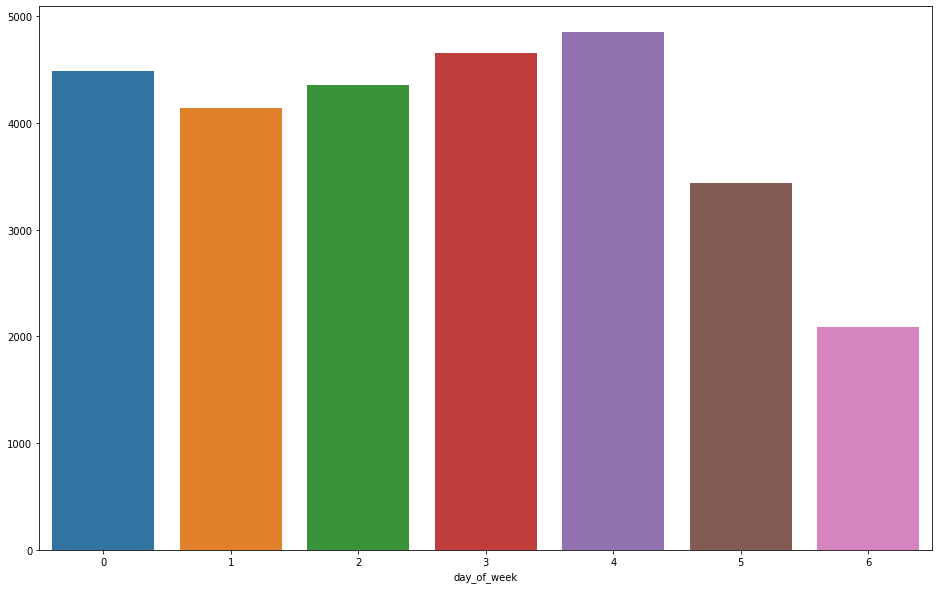

In [152]:
x = uio.groupby(['day_of_week'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


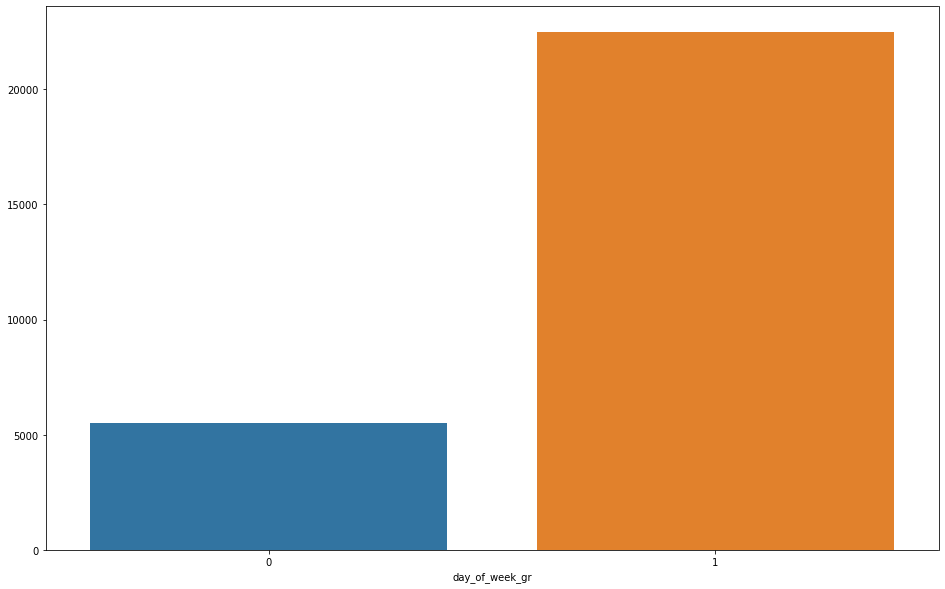

In [153]:
uio['day_of_week_gr'] = uio['day_of_week'].apply(lambda x: 1 if x in (0,1,2,3,4) else 0) # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
x = uio.groupby(['day_of_week_gr'])['id'].count()
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


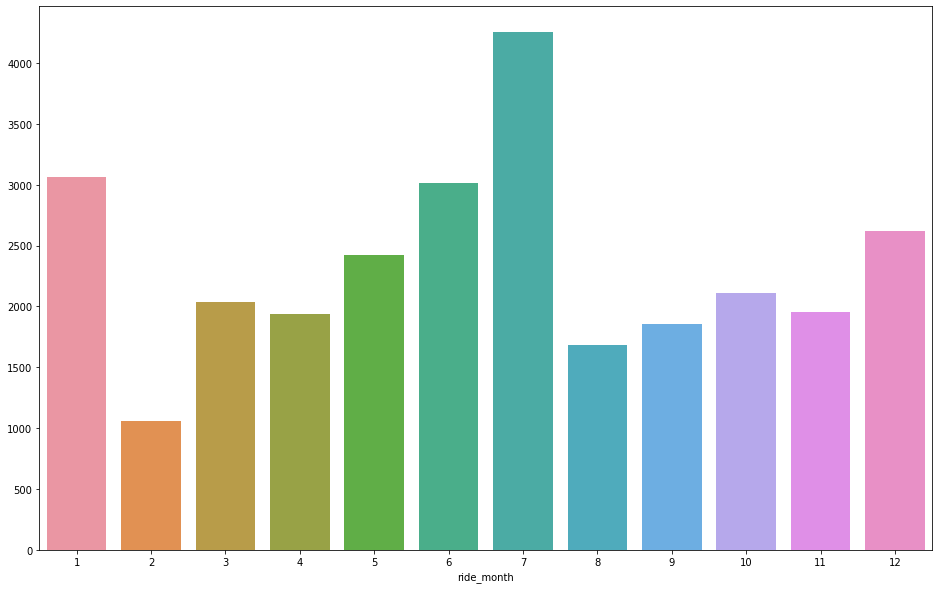

In [154]:
x = uio.groupby(['ride_month'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


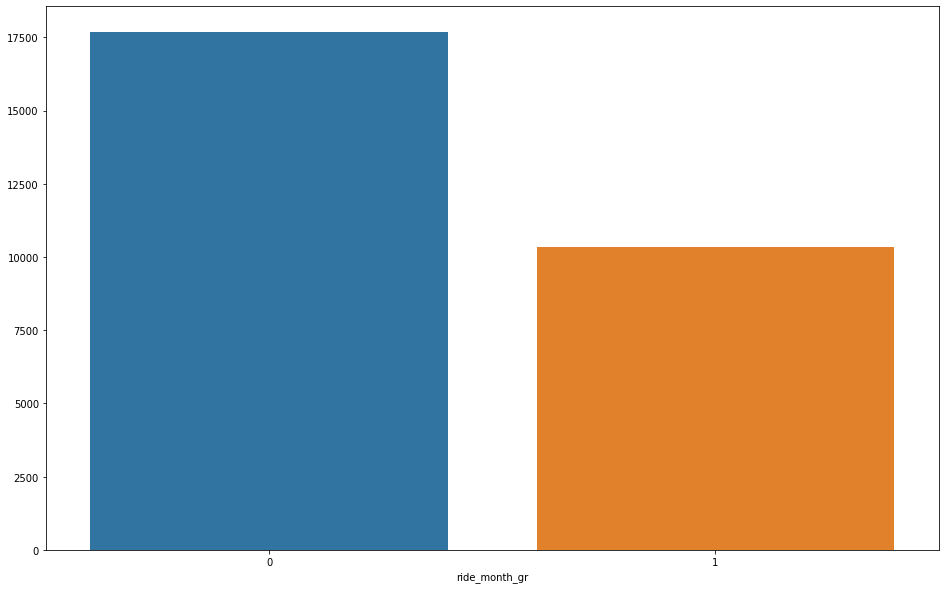

In [155]:
uio['ride_month_gr'] = uio['ride_month'].apply(lambda x: 1 if x in (1,6,7) else 0)
x = uio.groupby(['ride_month_gr'])['id'].count() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


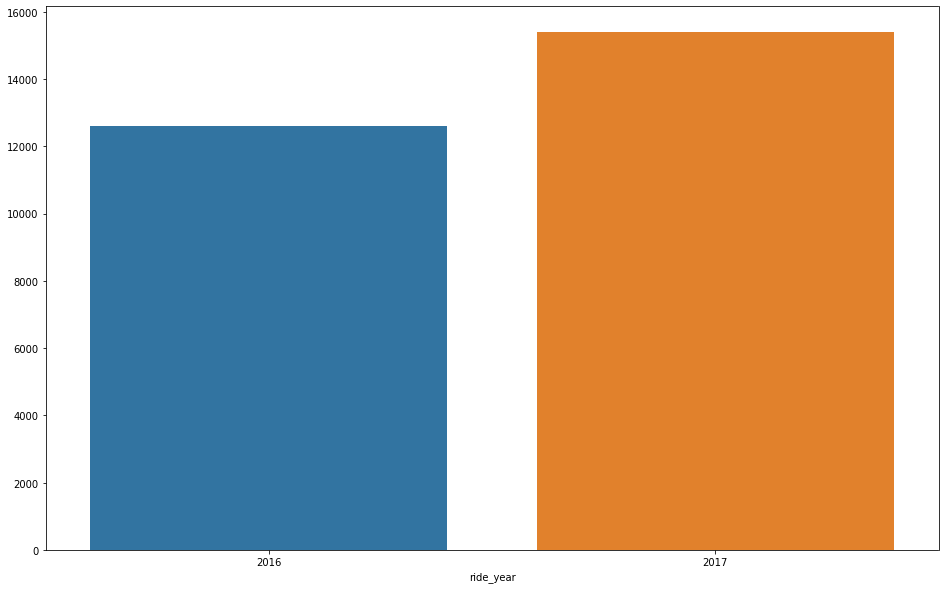

In [156]:
x = uio.groupby(['ride_year'])['id'].count() # There are more rides in 2017
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


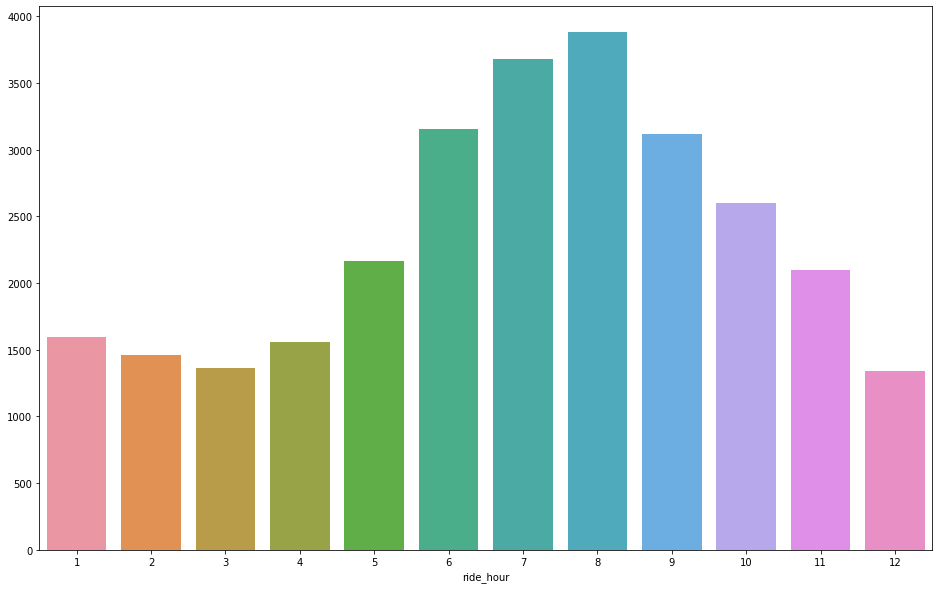

In [157]:
x = uio.groupby(['ride_hour'])['id'].count() # There is some seasonality based on the time of the day
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


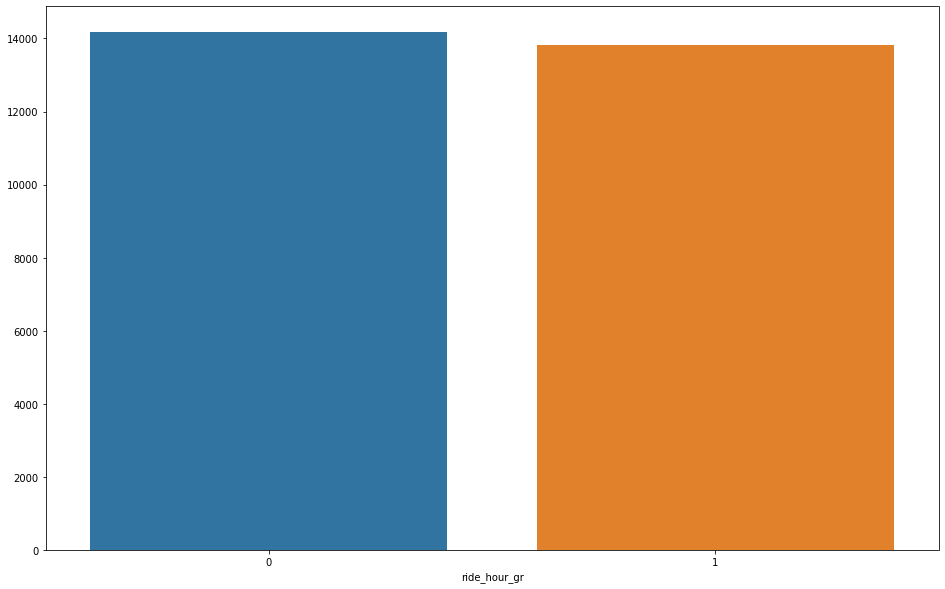

In [158]:
uio['ride_hour_gr'] = uio['ride_hour'].apply(lambda x: 1 if x in (6,7,8,9) else 0)  #flag set to 1 if rides are booked in these hours
x = uio.groupby(['ride_hour_gr'])['id'].count() # There is some seasonality based on the time of the day
sns.barplot(x.index, x.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

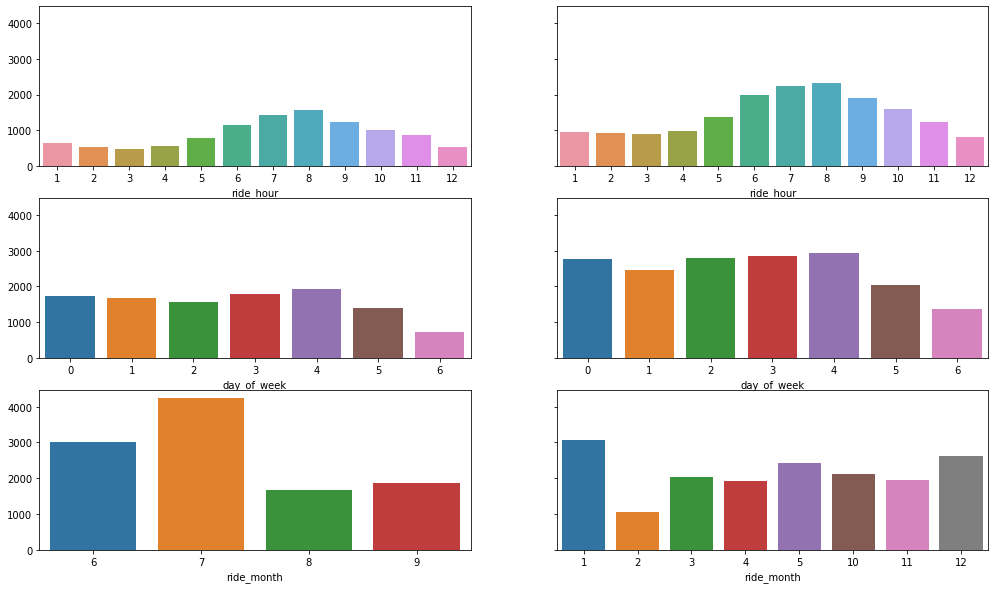

In [159]:
f, axes = plt.subplots(3,2,figsize=(17,10), sharey=True)

dat = uio[uio['season']==1].groupby(['ride_hour'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[0,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_hour'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[0,1])
#fig2.set_ylim = 3000

dat = uio[uio['season']==1].groupby(['day_of_week'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[1,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['day_of_week'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[1,1])

dat = uio[uio['season']==1].groupby(['ride_month'])['id'].count()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[2,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_month'])['id'].count()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[2,1])

In [160]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,day_of_week_gr,ride_month_gr,ride_hour_gr
count,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,...,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000
mean,16204.441957,-78.491643,-0.188040,-78.492087,-0.189661,20.692783,5.626063,6.410123,1.657026,6.541725,...,0.986038,2.425924,-0.000444,-0.001621,0.021460,2.796259,19.174782,0.802678,0.368863,0.493948
std,9332.618302,0.033030,0.065009,0.033455,0.066220,25.652666,5.566393,9.022761,1.109018,3.371535,...,0.117334,1.119830,0.020702,0.037311,0.144916,0.763743,10.480074,0.397984,0.482505,0.499972
min,1.000000,-79.933200,-2.875800,-79.933100,-2.875500,0.500000,0.020000,0.000000,1.000000,1.000000,...,0.000000,1.000000,-0.185100,-0.342300,0.000000,0.916291,0.007440,0.000000,0.000000,0.000000
25%,8170.000000,-78.505500,-0.216700,-78.504900,-0.218700,8.200000,2.247000,1.800000,1.000000,4.000000,...,1.000000,1.000000,-0.010100,-0.016600,0.000000,2.322388,12.937313,1.000000,0.000000,0.000000
50%,16210.000000,-78.489900,-0.181900,-78.489900,-0.185500,13.900000,4.067000,3.866667,1.000000,7.000000,...,1.000000,2.000000,-0.000100,-0.000200,0.000000,2.766319,18.334615,1.000000,0.000000,0.000000
75%,24299.000000,-78.475500,-0.149800,-78.477400,-0.151300,23.600000,7.070000,7.450000,2.000000,9.000000,...,1.000000,3.000000,0.009200,0.013500,0.000000,3.242592,24.195556,1.000000,1.000000,1.000000
max,32366.000000,-78.133000,0.866400,-78.133200,0.866800,349.683333,49.581000,99.933333,10.000000,12.000000,...,1.000000,4.000000,0.209300,0.346800,1.000000,5.862731,149.236364,1.000000,1.000000,1.000000


# **Feature Engineering Bearing** Ref 1
*horizontal angle between direction of an object and another object*

In [161]:
import math
def bearing_array(lat1, lng1, lat2, lng2):
    """bearing:
    horizontal angle between direction of an object and another object"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [162]:
uio.loc[:,'bearing'] = bearing_array(uio['pickup_latitude'].values, uio['pickup_longitude'].values, 
                               uio['dropoff_latitude'].values, uio['dropoff_longitude'].values)
uio.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,day_of_week_gr,ride_month_gr,ride_hour_gr,bearing
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,-78.5039,-0.2328,-78.5494,-0.3614,N,33.750000,...,3,-0.0455,-0.1285,0,3.576550,43.072000,0,0,1,-160.516053
1,2,Quito,2016-09-18 04:03:20,2016-09-18 04:26:30,-78.4403,0.0068,-78.4908,-0.1048,N,23.166667,...,1,-0.0505,-0.1116,0,3.225520,43.200000,0,0,0,-155.652847
3,4,Quito,2016-09-18 05:57:47,2016-09-18 06:30:00,-78.5581,-0.2782,-78.4302,-0.2019,N,32.216667,...,4,0.1279,0.0763,0,3.532713,46.831661,0,0,0,59.181455
4,5,Quito,2016-09-18 07:58:42,2016-09-18 08:14:29,-78.5218,-0.2085,-78.5046,-0.2225,N,15.800000,...,4,0.0173,-0.0140,0,2.879198,17.563291,0,0,1,129.144217
5,6,Quito,2016-08-27 04:19:02,2016-08-27 04:44:12,-78.5092,-0.1948,-78.5188,-0.2288,N,25.166667,...,2,-0.0096,-0.0340,0,3.301991,13.875497,0,0,0,-164.232937


# **Hitung Real Distance**

In [47]:
real_dist = uio[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','dist_meters']]

In [52]:
import geopy.distance

def calc_dist(lon1,lat1,lon2,lat2):
  coords_1 = (lat1, lon1)
  coords_2 = (lat2, lon2)
  return geopy.distance.geodesic(coords_1, coords_2).m

#real_dist['real_dist_meters'] = real_dist[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(calc_dist, axis=1)
real_dist['dist_meters_geopy'] =  real_dist.apply(lambda x: calc_dist(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [53]:
print(real_dist)

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0              -78.5039          -0.2328           -78.5494           -0.3614   
1              -78.4403           0.0068           -78.4908           -0.1048   
3              -78.5581          -0.2782           -78.4302           -0.2019   
4              -78.5218          -0.2085           -78.5046           -0.2225   
5              -78.5092          -0.1948           -78.5188           -0.2288   
...                 ...              ...                ...               ...   
32359          -78.5593          -0.2800           -78.5541           -0.3149   
32360          -78.5013          -0.2050           -78.4299           -0.3292   
32361          -78.4854          -0.1748           -78.4871           -0.1756   
32364          -78.5503          -0.2567           -78.5503           -0.2568   
32365          -78.4320          -0.3415           -78.4463           -0.3274   

       dist_meters  dist_me

In [54]:
uio['dist_meters_geopy'] =  uio.apply(lambda x: calc_dist(x['pickup_longitude'], x['pickup_latitude'], x['dropoff_longitude'], x['dropoff_latitude']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# **Drop Unused Table** Ref 1

In [163]:
uio = uio.drop(columns = ['vendor_id', 'dropoff_datetime', 'store_and_fwd_flag', 'pickup_datetime' ], axis=1)
uio.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,day_of_week_gr,ride_month_gr,ride_hour_gr,bearing
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,3,-0.0455,-0.1285,0,3.576550,43.072000,0,0,1,-160.516053
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,1,-0.0505,-0.1116,0,3.225520,43.200000,0,0,0,-155.652847
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,4,0.1279,0.0763,0,3.532713,46.831661,0,0,0,59.181455
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,4,0.0173,-0.0140,0,2.879198,17.563291,0,0,1,129.144217
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,2,-0.0096,-0.0340,0,3.301991,13.875497,0,0,0,-164.232937


In [164]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,minute_grp,diff_longitude,diff_latitude,holiday,trip_duration_log,average_speed,day_of_week_gr,ride_month_gr,ride_hour_gr,bearing
count,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,...,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000,28005.000000
mean,16204.441957,-78.491643,-0.188040,-78.492087,-0.189661,20.692783,5.626063,6.410123,1.657026,6.541725,...,2.425924,-0.000444,-0.001621,0.021460,2.796259,19.174782,0.802678,0.368863,0.493948,-14.670576
std,9332.618302,0.033030,0.065009,0.033455,0.066220,25.652666,5.566393,9.022761,1.109018,3.371535,...,1.119830,0.020702,0.037311,0.144916,0.763743,10.480074,0.397984,0.482505,0.499972,107.972163
min,1.000000,-79.933200,-2.875800,-79.933100,-2.875500,0.500000,0.020000,0.000000,1.000000,1.000000,...,1.000000,-0.185100,-0.342300,0.000000,0.916291,0.007440,0.000000,0.000000,0.000000,-179.918615
25%,8170.000000,-78.505500,-0.216700,-78.504900,-0.218700,8.200000,2.247000,1.800000,1.000000,4.000000,...,1.000000,-0.010100,-0.016600,0.000000,2.322388,12.937313,1.000000,0.000000,0.000000,-124.100648
50%,16210.000000,-78.489900,-0.181900,-78.489900,-0.185500,13.900000,4.067000,3.866667,1.000000,7.000000,...,2.000000,-0.000100,-0.000200,0.000000,2.766319,18.334615,1.000000,0.000000,0.000000,-0.528868
75%,24299.000000,-78.475500,-0.149800,-78.477400,-0.151300,23.600000,7.070000,7.450000,2.000000,9.000000,...,3.000000,0.009200,0.013500,0.000000,3.242592,24.195556,1.000000,1.000000,1.000000,62.367390
max,32366.000000,-78.133000,0.866400,-78.133200,0.866800,349.683333,49.581000,99.933333,10.000000,12.000000,...,4.000000,0.209300,0.346800,1.000000,5.862731,149.236364,1.000000,1.000000,1.000000,180.000000


# **Visualize Data trip_duration VS Other Columns**

In [ ]:
x = uio.groupby(['ride_month'])['trip_duration'].mean() # There is some seasonality as the months of May to Jul and Nov-Dec have higher rides count
sns.barplot(x.index, x.values)

In [ ]:
x = uio.groupby(['ride_hour'])['trip_duration'].mean() # There is some seasonality based on the time of the day
sns.barplot(x.index, x.values)
plt.show()

In [ ]:
x = uio.groupby(['day_of_week_gr'])['trip_duration'].mean()
sns.barplot(x.index, x.values)

In [ ]:
f, axes = plt.subplots(3,2,figsize=(17,10), sharey=True)

dat = uio[uio['season']==1].groupby(['ride_hour'])['trip_duration'].mean()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[0,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_hour'])['trip_duration'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[0,1])
#fig2.set_ylim = 3000

dat = uio[uio['season']==1].groupby(['day_of_week'])['trip_duration'].mean()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[1,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['day_of_week'])['trip_duration'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[1,1])

dat = uio[uio['season']==1].groupby(['ride_month'])['trip_duration'].mean()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[2,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_month'])['trip_duration'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[2,1])

# **Visualize Data dist_meters VS Other Columns**

In [ ]:
f, axes = plt.subplots(3,2,figsize=(17,10), sharey=True)

dat = uio[uio['season']==1].groupby(['ride_hour'])['dist_meters'].mean()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[0,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_hour'])['dist_meters'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[0,1])
#fig2.set_ylim = 3000

dat = uio[uio['season']==1].groupby(['day_of_week'])['dist_meters'].mean()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[1,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['day_of_week'])['dist_meters'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[1,1])

dat = uio[uio['season']==1].groupby(['ride_month'])['dist_meters'].mean()
fig1 = sns.barplot(dat.index, dat.values, ax=axes[2,0])
#fig1.set_ylim = 3000

dat = uio[uio['season']==0].groupby(['ride_month'])['dist_meters'].mean()
fig2 = sns.barplot(dat.index, dat.values, ax=axes[2,1])

# **Clustering Coordinates** Ref 3 (most recommend)

In [45]:
from sklearn.cluster import KMeans

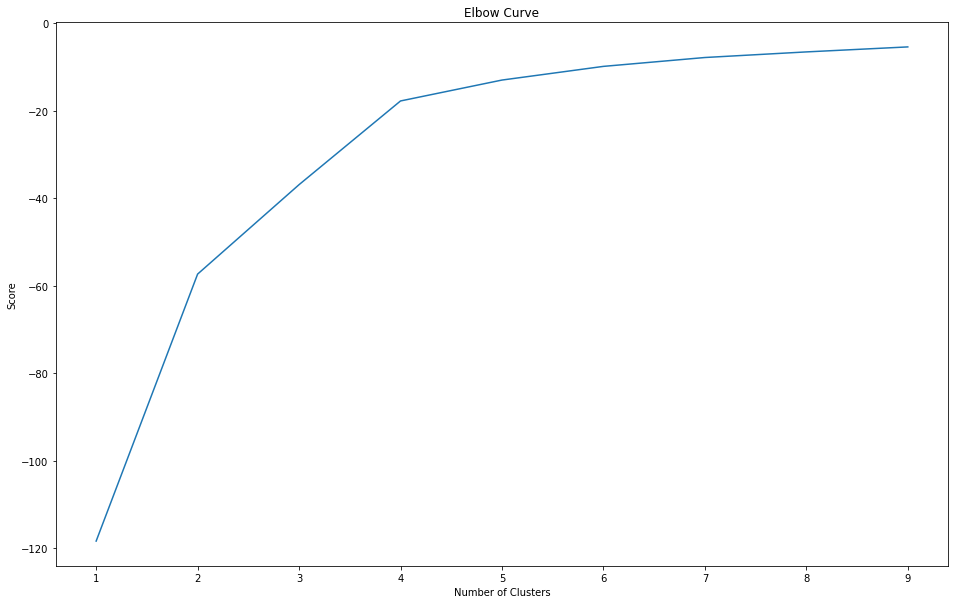

In [46]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['pickup_latitude']]
X_axis = uio[['pickup_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [47]:
kmeans = KMeans(n_clusters = 4, init ='k-means++', max_iter=100, n_init=1, verbose=0, random_state=3425)
kmeans.fit(uio[['pickup_latitude', 'pickup_longitude']]) # Compute k-means clustering.
uio['cluster_pickup_ref3'] = kmeans.fit_predict(uio[['pickup_latitude', 'pickup_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['pickup_latitude', 'pickup_longitude']]) # Labels of each point
uio.head(10)

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,ride_hour,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,cluster_pickup_ref3
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,9,32,5,1,1,3,-0.0455,-0.1285,0,1
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,4,3,6,1,1,1,-0.0505,-0.1116,0,2
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,5,57,6,1,1,4,0.1279,0.0763,0,1
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,7,58,6,1,1,4,0.0173,-0.0140,0,0
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,4,19,5,1,1,2,-0.0096,-0.0340,0,0
6,7,-78.4815,-0.1543,-78.5184,-0.1915,22.350000,7.593,8.500000,2,9,...,10,8,6,1,1,1,-0.0369,-0.0372,0,0
7,8,-78.5298,-0.2491,-78.3611,-0.1246,47.016667,46.418,5.033333,10,9,...,11,6,6,1,1,1,0.1687,0.1245,0,1
8,9,-78.3611,-0.1246,-78.3927,-0.0894,18.333333,8.150,6.500000,2,9,...,11,54,6,1,1,4,-0.0317,0.0352,0,2
9,10,-78.4971,-0.2004,-78.4998,-0.2073,1.816667,0.827,0.483333,1,9,...,12,21,6,1,1,2,-0.0026,-0.0069,0,0
10,11,-78.4998,-0.2073,-78.5068,-0.2260,8.250000,2.549,2.150000,1,9,...,12,23,6,1,1,2,-0.0070,-0.0187,0,0


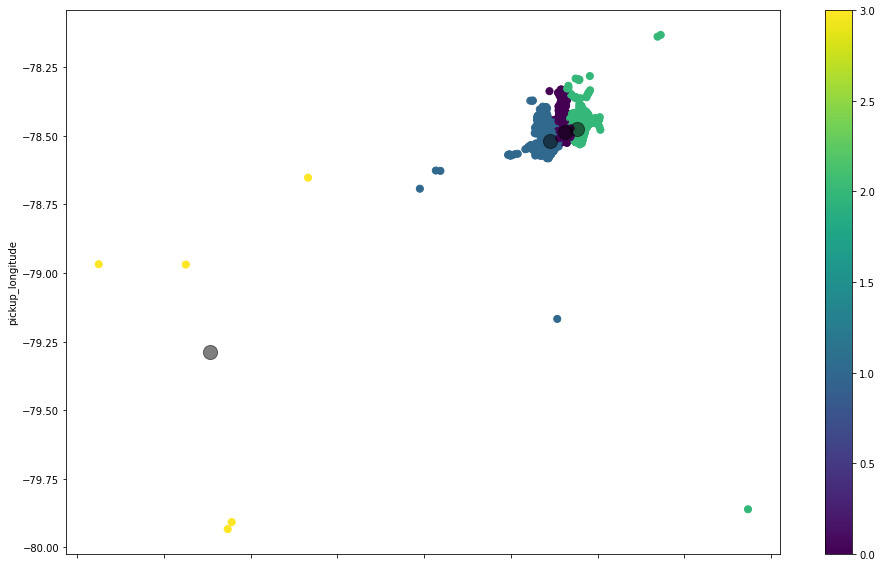

In [48]:
uio.plot.scatter(x = 'pickup_latitude', y = 'pickup_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


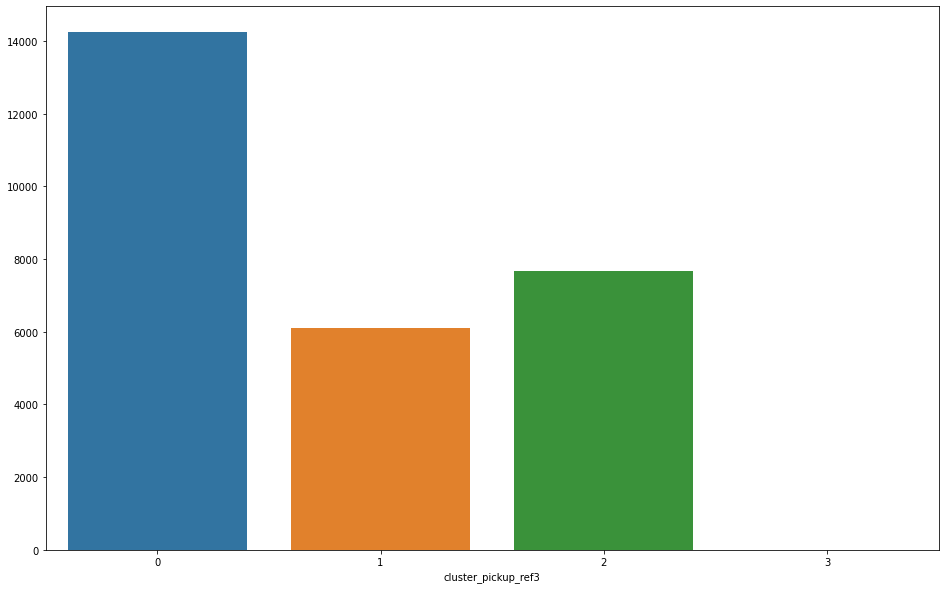

In [49]:
x = uio.groupby(['cluster_pickup_ref3'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

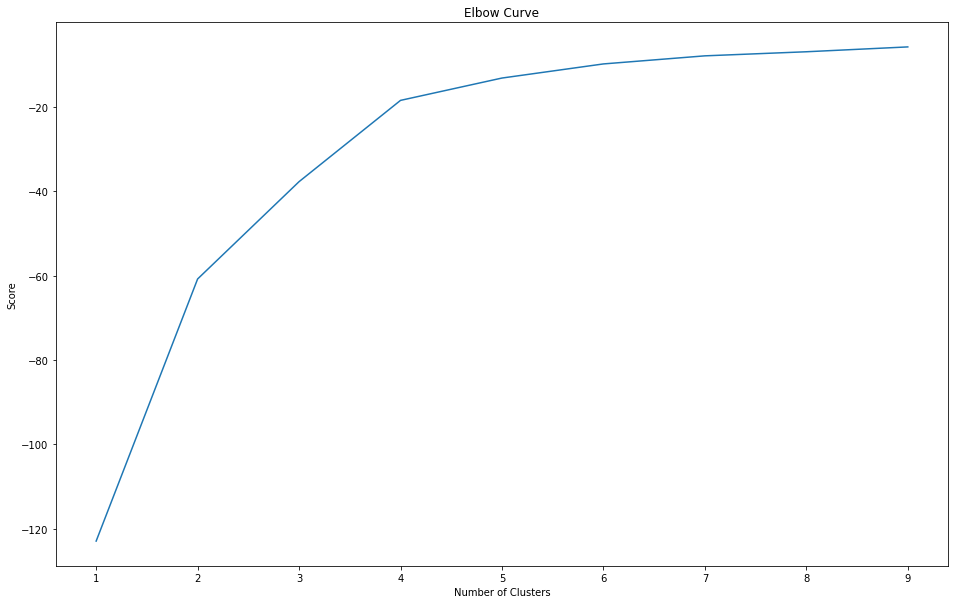

In [50]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = uio[['dropoff_latitude']]
X_axis = uio[['dropoff_longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [51]:
kmeans = KMeans(n_clusters = 4, init ='k-means++', max_iter=100, n_init=1, verbose=0, random_state=3425)
kmeans.fit(uio[['dropoff_latitude', 'dropoff_longitude']]) # Compute k-means clustering.
uio['cluster_dropoff_ref3'] = kmeans.fit_predict(uio[['dropoff_latitude', 'dropoff_longitude']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(uio[['dropoff_latitude', 'dropoff_longitude']]) # Labels of each point
uio.head(10)

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,cluster_pickup_ref3,cluster_dropoff_ref3
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,32,5,1,1,3,-0.0455,-0.1285,0,1,1
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,3,6,1,1,1,-0.0505,-0.1116,0,2,2
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,57,6,1,1,4,0.1279,0.0763,0,1,0
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,58,6,1,1,4,0.0173,-0.0140,0,0,0
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,19,5,1,1,2,-0.0096,-0.0340,0,0,1
6,7,-78.4815,-0.1543,-78.5184,-0.1915,22.350000,7.593,8.500000,2,9,...,8,6,1,1,1,-0.0369,-0.0372,0,0,0
7,8,-78.5298,-0.2491,-78.3611,-0.1246,47.016667,46.418,5.033333,10,9,...,6,6,1,1,1,0.1687,0.1245,0,1,2
8,9,-78.3611,-0.1246,-78.3927,-0.0894,18.333333,8.150,6.500000,2,9,...,54,6,1,1,4,-0.0317,0.0352,0,2,2
9,10,-78.4971,-0.2004,-78.4998,-0.2073,1.816667,0.827,0.483333,1,9,...,21,6,1,1,2,-0.0026,-0.0069,0,0,0
10,11,-78.4998,-0.2073,-78.5068,-0.2260,8.250000,2.549,2.150000,1,9,...,23,6,1,1,2,-0.0070,-0.0187,0,0,0


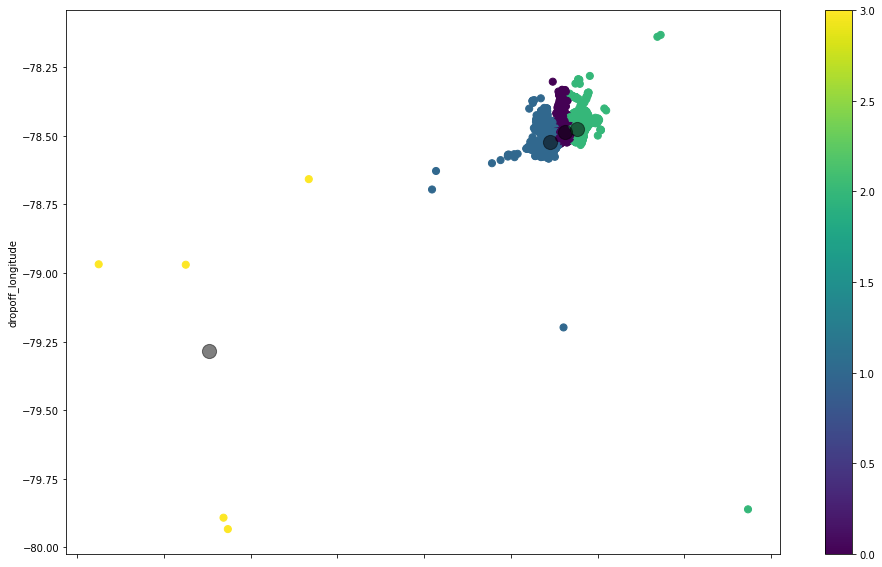

In [52]:
uio.plot.scatter(x = 'dropoff_latitude', y = 'dropoff_longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


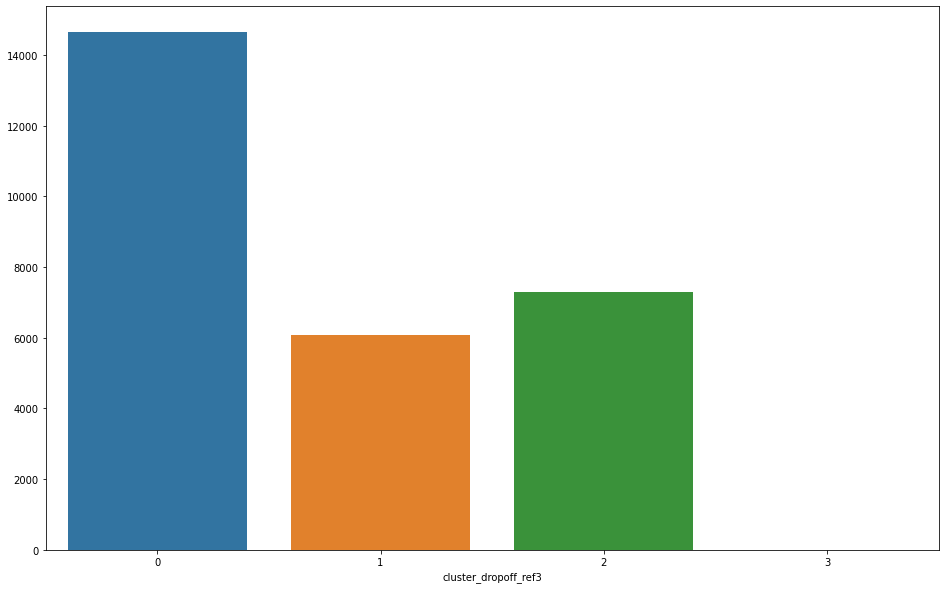

In [53]:
x = uio.groupby(['cluster_dropoff_ref3'])['id'].count()
sns.barplot(x.index, x.values)
plt.show()

# **Clustering Coordinate** Ref 2

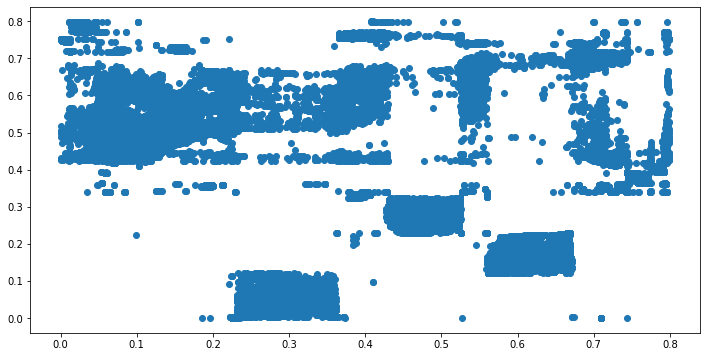

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(uio['pickup_latitude'], uio['pickup_longitude'])
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=10)

uio['cluster_ref2'] = kmeans.fit_predict(uio[['pickup_latitude', 'pickup_longitude']])

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 0], uio['pickup_longitude'][uio['cluster_ref2'] == 0], c='r', label='c0')
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 1], uio['pickup_longitude'][uio['cluster_ref2'] == 1], c='y', label='c1')
plt.scatter(uio['pickup_latitude'][uio['cluster_ref2'] == 2], uio['pickup_longitude'][uio['cluster_ref2'] == 2], c='g', label='c2')
plt.legend()
plt.show()

# **Cluestering Coordinate**  Ref 1

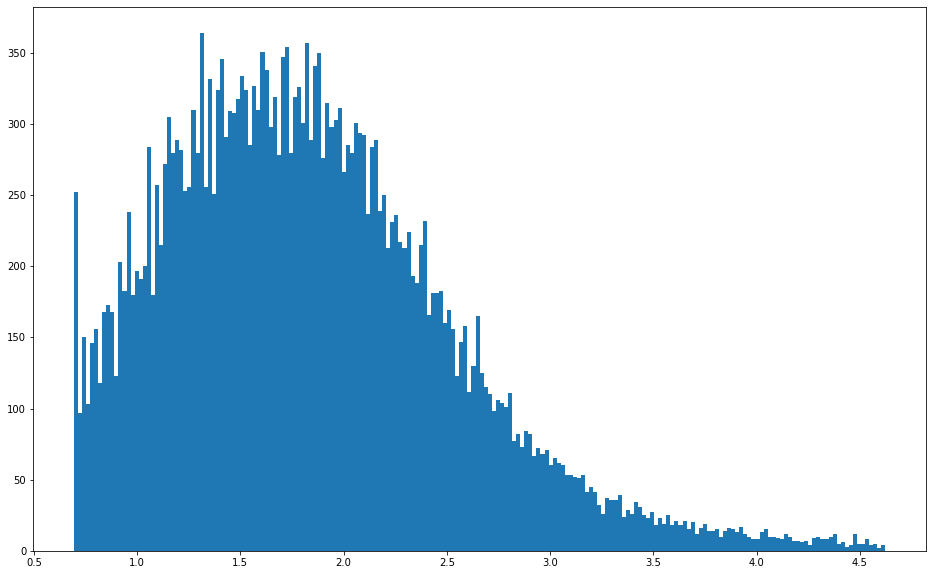

In [167]:
dat = uio
y = np.log1p(dat['wait_sec'] + 1)
x = dat.drop(['wait_sec'], axis = 1)
plt.hist(y, bins=200)
plt.show()

In [168]:
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size = 0.2, shuffle=True, random_state = 65).copy()

In [169]:
print("Shape of X train", train_X.shape)
print("Shape of Y train", train_Y.shape)
print("Shape of X test", test_X.shape)
print("Shape of Y test", test_Y.shape)

Shape of X train (22404, 26)
Shape of Y train (22404,)
Shape of X test (5601, 26)
Shape of Y test (5601,)


In [170]:
coordinates = np.vstack((train_X[['pickup_latitude', 'pickup_longitude']].values, train_X[['dropoff_latitude', 'dropoff_longitude']].values))

In [171]:
scaler = StandardScaler()
coordinates_std = scaler.fit_transform(coordinates)
clustering = MiniBatchKMeans(n_clusters=70, random_state=203, batch_size=10000)
model = clustering.fit(coordinates_std)

In [172]:
X_Tr = train_X.copy().reset_index().drop('index', axis=1)
Y_Tr = train_Y.copy().reset_index().drop('index', axis=1)
X_Te = test_X.copy().reset_index().drop('index', axis=1)
Y_Te = test_Y.copy().reset_index().drop('index', axis=1)

X_Tr['kms_pick_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Tr[['pickup_latitude', 'pickup_longitude']])))
X_Tr['kms_drop_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Tr[['dropoff_latitude', 'dropoff_longitude']])))
X_Te['kms_pick_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Te[['pickup_latitude', 'pickup_longitude']])))
X_Te['kms_drop_cluster'] = pd.Series(model.predict(scaler.fit_transform(X_Te[['dropoff_latitude', 'dropoff_longitude']])))

In [173]:
X_Tr.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,day_of_week_gr,ride_month_gr,ride_hour_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,2515,-78.4978,-0.1272,-78.5009,-0.1279,27.933333,0.363,1,3,2017,...,-0.0007,0,3.398973,0.779714,1,0,1,-102.724390,5,5
1,32018,-78.5229,-0.2427,-78.5267,-0.2428,4.166667,0.443,1,10,2016,...,-0.0001,0,1.819158,6.379200,1,0,0,-91.507457,64,64
2,7498,-78.5035,-0.1830,-78.4815,-0.1815,11.716667,4.128,1,9,2016,...,0.0015,0,2.618612,21.139118,0,0,0,86.099522,42,23
3,1062,-78.5072,-0.1827,-78.5034,-0.1832,12.533333,3.374,1,8,2016,...,-0.0005,0,2.676445,16.152128,1,0,0,97.495901,42,42
4,9601,-78.5052,-0.1341,-78.4916,-0.1042,10.166667,5.117,2,1,2017,...,0.0299,0,2.498700,30.198689,0,1,0,24.458358,50,54


In [174]:
X_Te.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,day_of_week_gr,ride_month_gr,ride_hour_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,13363,-78.5006,-0.2107,-78.5034,-0.1939,19.266667,1.906,1,11,2016,...,0.0169,0,3.057141,5.935640,1,0,1,-9.462269,60,24
1,31696,-78.5572,-0.3488,-78.5566,-0.3485,1.150000,0.122,1,10,2016,...,0.0003,0,1.147402,6.365217,1,0,0,63.434526,51,51
2,991,-78.5375,-0.2638,-78.5079,-0.2367,20.166667,9.941,2,4,2017,...,0.0271,0,3.098590,29.576529,0,0,0,47.524427,56,58
3,5936,-78.4861,-0.1635,-78.4841,-0.0947,63.383333,17.333,4,10,2016,...,0.0687,0,4.180267,16.407783,0,0,1,1.665104,65,37
4,8527,-78.4266,-0.3039,-78.4622,-0.3250,15.416667,6.495,2,1,2017,...,-0.0211,0,2.857428,25.277838,0,1,0,-120.655555,39,6


In [175]:

print(X_Tr.shape)
print(Y_Tr.shape)
print(X_Te.shape)
print(Y_Te.shape)

print(X_Tr['kms_pick_cluster'].isna().sum())
print(X_Tr['kms_drop_cluster'].isna().sum())
print(X_Te['kms_pick_cluster'].isna().sum())
print(X_Te['kms_drop_cluster'].isna().sum())

(22404, 28)
(22404, 1)
(5601, 28)
(5601, 1)
0
0
0
0


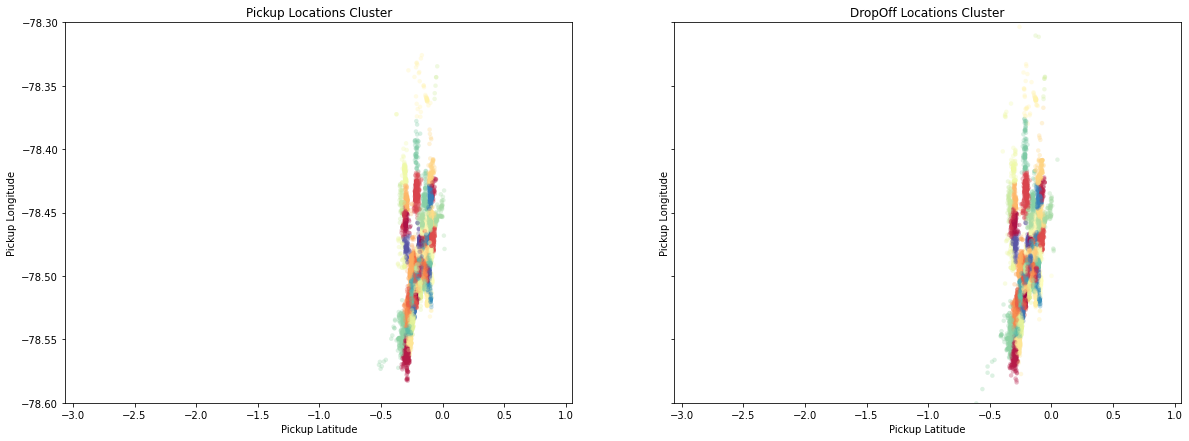

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True)
axes[0].scatter(X_Tr['pickup_latitude'], X_Tr['pickup_longitude'], c=X_Tr['kms_pick_cluster'], alpha=0.3, lw = 0, s=20, cmap='Spectral')
axes[0].set_title('Pickup Locations Cluster')
axes[0].set_xlabel('Pickup Latitude')
axes[0].set_ylabel('Pickup Longitude')
axes[0].set_ylim([-78.6, -78.3])

axes[1].scatter(X_Tr['dropoff_latitude'], X_Tr['dropoff_longitude'], c=X_Tr['kms_drop_cluster'], alpha=0.3, lw = 0, s=20, cmap='Spectral')
axes[1].set_title('DropOff Locations Cluster')
axes[1].set_xlabel('Pickup Latitude')
axes[1].set_ylabel('Pickup Longitude')
plt.show()

In [177]:
X_Tr.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,ride_length_grp,ride_month,ride_year,...,diff_latitude,holiday,trip_duration_log,average_speed,day_of_week_gr,ride_month_gr,ride_hour_gr,bearing,kms_pick_cluster,kms_drop_cluster
0,2515,-78.4978,-0.1272,-78.5009,-0.1279,27.933333,0.363,1,3,2017,...,-0.0007,0,3.398973,0.779714,1,0,1,-102.724390,5,5
1,32018,-78.5229,-0.2427,-78.5267,-0.2428,4.166667,0.443,1,10,2016,...,-0.0001,0,1.819158,6.379200,1,0,0,-91.507457,64,64
2,7498,-78.5035,-0.1830,-78.4815,-0.1815,11.716667,4.128,1,9,2016,...,0.0015,0,2.618612,21.139118,0,0,0,86.099522,42,23
3,1062,-78.5072,-0.1827,-78.5034,-0.1832,12.533333,3.374,1,8,2016,...,-0.0005,0,2.676445,16.152128,1,0,0,97.495901,42,42
4,9601,-78.5052,-0.1341,-78.4916,-0.1042,10.166667,5.117,2,1,2017,...,0.0299,0,2.498700,30.198689,0,1,0,24.458358,50,54


# **Check Correlation**

In [54]:
import pandas as pd
from sklearn import preprocessing

x = uio.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

df.columns = [list(uio.columns)]
print(df)

             id pickup_longitude pickup_latitude dropoff_longitude  \
0      0.000000         0.793967        0.706269          0.768765   
1      0.000031         0.829297        0.770296          0.801322   
2      0.000093         0.763860        0.694137          0.834991   
3      0.000124         0.784024        0.712763          0.793655   
4      0.000154         0.791023        0.716423          0.785766   
...         ...              ...             ...               ...   
28018  0.999815         0.763193        0.693656          0.766154   
28019  0.999846         0.795412        0.713698          0.835158   
28020  0.999876         0.804244        0.721768          0.803378   
28021  0.999969         0.768192        0.699882          0.768265   
28022  1.000000         0.833907        0.677222          0.826046   

      dropoff_latitude trip_duration dist_meters  wait_sec ride_length_grp  \
0             0.671806      0.095222    0.488449  0.057705        0.444444   
1  

In [60]:
correlation_matrix = df.corr()
print(correlation_matrix['trip_duration'])

                     trip_duration
id                       -0.006372
pickup_longitude          0.004184
pickup_latitude           0.008243
dropoff_longitude        -0.005981
dropoff_latitude         -0.014755
trip_duration             1.000000
dist_meters               0.488574
wait_sec                  0.536364
ride_length_grp           0.474133
ride_month                0.017809
ride_year                -0.014448
ride_day                 -0.001657
ride_hour                -0.076570
ride_minute              -0.013727
day_of_week               0.006819
season                   -0.020957
vendor_flg               -0.013914
minute_grp               -0.009830
diff_longitude           -0.016328
diff_latitude            -0.040557
holiday                  -0.001918
cluster_pickup_ref3       0.041701
cluster_dropoff_ref3      0.029811


In [55]:
correlation_matrix = df.corr()
print(correlation_matrix['trip_duration'].abs() > 0.5)

                     trip_duration
id                           False
pickup_longitude             False
pickup_latitude              False
dropoff_longitude            False
dropoff_latitude             False
trip_duration                 True
dist_meters                  False
wait_sec                      True
ride_length_grp              False
ride_month                   False
ride_year                    False
ride_day                     False
ride_hour                    False
ride_minute                  False
day_of_week                  False
season                       False
vendor_flg                   False
minute_grp                   False
diff_longitude               False
diff_latitude                False
holiday                      False
cluster_pickup_ref3          False
cluster_dropoff_ref3         False


In [61]:
correlation_matrix = df.corr()
print(correlation_matrix['dist_meters'])

                     dist_meters
id                      0.002974
pickup_longitude        0.051699
pickup_latitude         0.016266
dropoff_longitude       0.030145
dropoff_latitude       -0.020689
trip_duration           0.488574
dist_meters             1.000000
wait_sec                0.349334
ride_length_grp         0.967622
ride_month              0.015520
ride_year              -0.010253
ride_day                0.000437
ride_hour              -0.015472
ride_minute            -0.009730
day_of_week             0.048731
season                 -0.009205
vendor_flg              0.008074
minute_grp             -0.008063
diff_longitude         -0.033785
diff_latitude          -0.065069
holiday                 0.010392
cluster_pickup_ref3     0.099601
cluster_dropoff_ref3    0.107096


In [56]:
correlation_matrix = df.corr()
print(correlation_matrix['dist_meters'].abs() > 0.5)

                     dist_meters
id                         False
pickup_longitude           False
pickup_latitude            False
dropoff_longitude          False
dropoff_latitude           False
trip_duration              False
dist_meters                 True
wait_sec                   False
ride_length_grp             True
ride_month                 False
ride_year                  False
ride_day                   False
ride_hour                  False
ride_minute                False
day_of_week                False
season                     False
vendor_flg                 False
minute_grp                 False
diff_longitude             False
diff_latitude              False
holiday                    False
cluster_pickup_ref3        False
cluster_dropoff_ref3       False


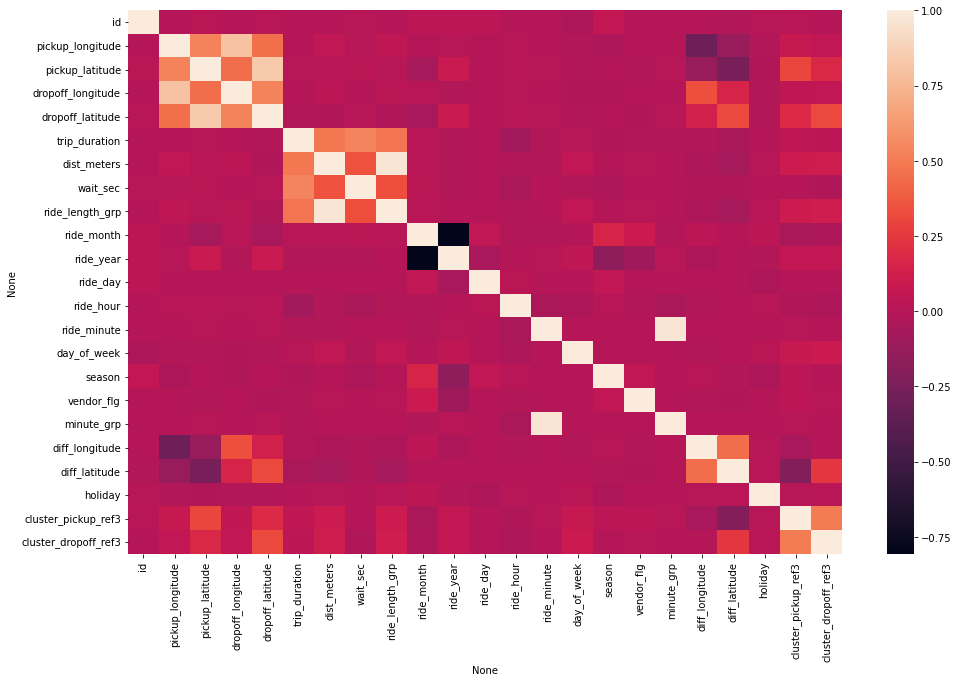

In [57]:
sns.heatmap(df.corr());

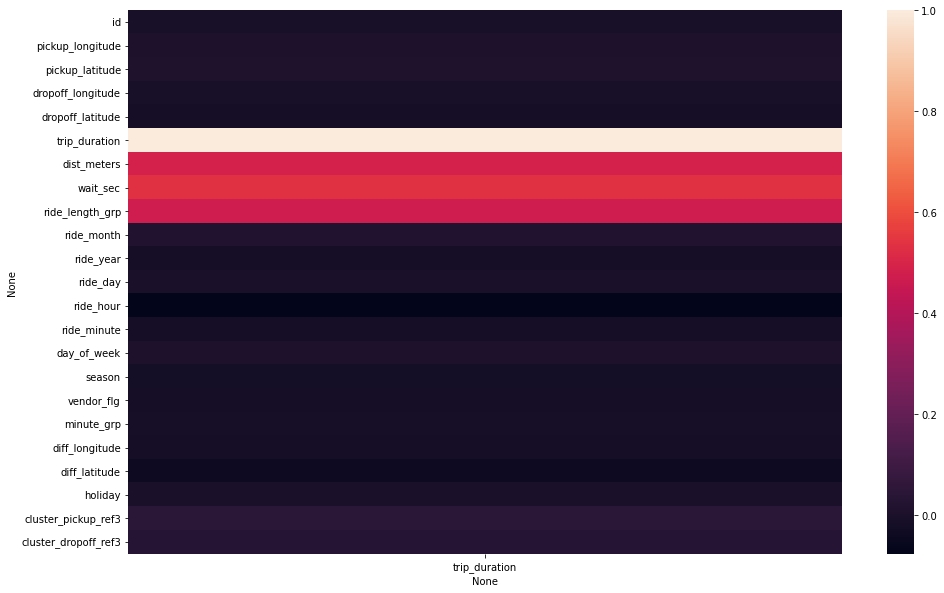

In [58]:
sns.heatmap(correlation_matrix['trip_duration']);

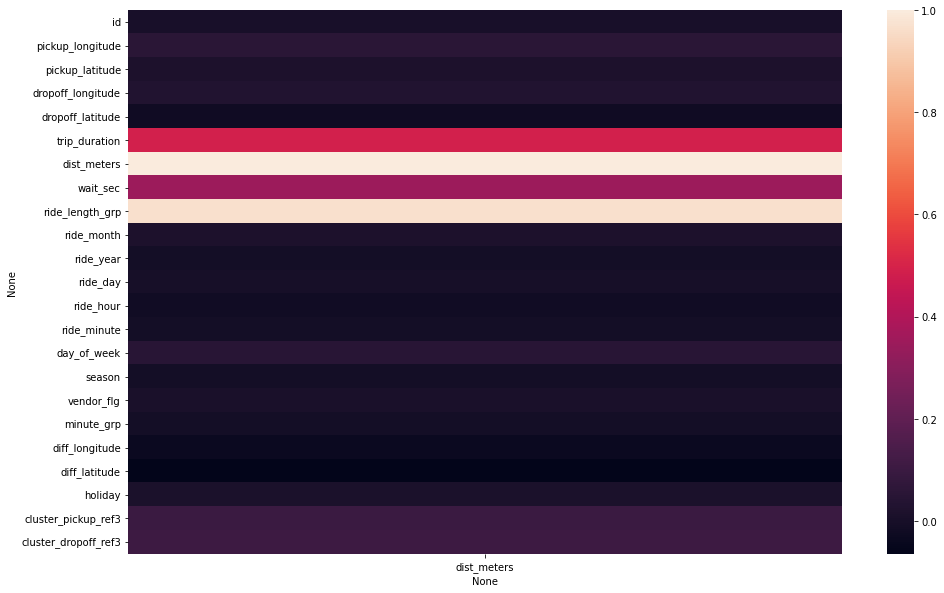

In [59]:
sns.heatmap(correlation_matrix['dist_meters']);

# **Hasil Akhir Tabel**

In [62]:
uio.head()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,cluster_pickup_ref3,cluster_dropoff_ref3
0,1,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,...,32,5,1,1,3,-0.0455,-0.1285,0,1,1
1,2,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,...,3,6,1,1,1,-0.0505,-0.1116,0,2,2
3,4,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,...,57,6,1,1,4,0.1279,0.0763,0,1,0
4,5,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,...,58,6,1,1,4,0.0173,-0.0140,0,0,0
5,6,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,...,19,5,1,1,2,-0.0096,-0.0340,0,0,1


In [63]:
uio.describe()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,...,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,cluster_pickup_ref3,cluster_dropoff_ref3
count,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,...,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000,28023.000000
mean,16204.706420,-78.491650,-0.188046,-78.492094,-0.189666,20.681937,5.630726,6.406819,1.657960,6.541056,...,29.063412,2.711630,0.385897,0.986011,2.426007,-0.000444,-0.001620,0.021447,0.766156,0.738536
std,9331.393756,0.033034,0.065007,0.033457,0.066221,25.648180,5.576272,9.020875,1.111103,3.371246,...,17.355614,1.855022,0.486815,0.117445,1.119929,0.020698,0.037313,0.144870,0.853325,0.846031
min,1.000000,-79.933200,-2.875800,-79.933100,-2.875500,0.500000,0.020000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,-0.185100,-0.342300,0.000000,0.000000,0.000000
25%,8171.500000,-78.505500,-0.216700,-78.504900,-0.218700,8.183333,2.247000,1.783333,1.000000,4.000000,...,14.000000,1.000000,0.000000,1.000000,1.000000,-0.010100,-0.016600,0.000000,0.000000,0.000000
50%,16211.000000,-78.489900,-0.181900,-78.489900,-0.185600,13.900000,4.070000,3.866667,1.000000,7.000000,...,29.000000,3.000000,0.000000,1.000000,2.000000,-0.000100,-0.000200,0.000000,0.000000,0.000000
75%,24295.500000,-78.475500,-0.149750,-78.477400,-0.151300,23.600000,7.072000,7.433333,2.000000,9.000000,...,44.000000,4.000000,1.000000,1.000000,3.000000,0.009200,0.013500,0.000000,2.000000,2.000000
max,32366.000000,-78.133000,0.866400,-78.133200,0.866800,349.683333,49.581000,99.933333,10.000000,12.000000,...,59.000000,6.000000,1.000000,1.000000,4.000000,0.209300,0.346800,1.000000,3.000000,3.000000


In [64]:
uio = uio.drop(columns = ['id'], axis=1)

In [65]:
uio.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,ride_length_grp,ride_month,ride_year,...,ride_minute,day_of_week,season,vendor_flg,minute_grp,diff_longitude,diff_latitude,holiday,cluster_pickup_ref3,cluster_dropoff_ref3
0,-78.5039,-0.2328,-78.5494,-0.3614,33.750000,24.228,5.766667,5,9,2016,...,32,5,1,1,3,-0.0455,-0.1285,0,1,1
1,-78.4403,0.0068,-78.4908,-0.1048,23.166667,16.680,7.600000,4,9,2016,...,3,6,1,1,1,-0.0505,-0.1116,0,2,2
3,-78.5581,-0.2782,-78.4302,-0.2019,32.216667,25.146,5.033333,6,9,2016,...,57,6,1,1,4,0.1279,0.0763,0,1,0
4,-78.5218,-0.2085,-78.5046,-0.2225,15.800000,4.625,5.233333,1,9,2016,...,58,6,1,1,4,0.0173,-0.0140,0,0,0
5,-78.5092,-0.1948,-78.5188,-0.2288,25.166667,5.820,10.500000,2,8,2016,...,19,5,1,1,2,-0.0096,-0.0340,0,0,1


# **Prediction** Ref 1 SKIP

In [178]:
train_X, test_X, train_Y, test_Y = train_test_split(x, y, test_size = 0.2, shuffle=True, random_state = 65).copy()

In [179]:
d_Tr = xgb.DMatrix(X_Tr, label=Y_Tr)
d_Te = xgb.DMatrix(X_Te)

In [180]:
def xgb_evaluate(max_depth, gamma,min_child_weight,max_delta_step,subsample,colsample_bytree, eta):
    params = {'eval_metric': 'rmse',
                  'max_depth': int(max_depth),
                  'subsample': subsample,
                  'eta': eta,
                  'gamma': gamma,
                  'colsample_bytree': colsample_bytree,   
                  'min_child_weight': min_child_weight ,
                  'max_delta_step':max_delta_step
                 }
    # Use cross validation to avoid over fitting
    cv_result = xgb.cv(params, d_Tr, num_boost_round=1000, nfold=3, metrics = "rmse", early_stopping_rounds=10, seed=3113)    
    print("Number of Trees", cv_result.shape[0])
        
    # Returning negative of RMSE since Bayesian optimization only knows how to maximize
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [181]:
%%time
xgb_bo = BayesianOptimization(xgb_evaluate, {
    'eta': (0.01, 0.1),
    'max_depth': (2, 6),
    'gamma': (0, 5),
    'min_child_weight': (1, 20),
    'max_delta_step': (0, 10),
    'subsample': (0.2, 1),
    'colsample_bytree' :(0.2, 0.8)})

# Use the expected improvement acquisition function to handle negative numbers
# Optimally needs quite a few more initiation points and number of iterations
xgb_bo.maximize(init_points=5, n_iter=50, acq='ei')

|   iter    |  target   | colsam... |    eta    |   gamma   | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
Number of Trees 137
|  1        | -0.4056   |  0.3897   |  0.09747  |  4.327    |  1.049    |  4.449    |  16.13    |  0.4651   |
Number of Trees 67
|  2        | -0.4048   |  0.7415   |  0.08737  |  0.8503   |  5.707    |  5.732    |  3.552    |  0.6127   |
Number of Trees 98
|  3        | -0.4043   |  0.7488   |  0.06415  |  2.173    |  7.488    |  5.098    |  10.28    |  0.2905   |
Number of Trees 804
|  4        | -0.4025   |  0.6148   |  0.01266  |  0.9861   |  8.165    |  3.023    |  12.1     |  0.4079   |
Number of Trees 230
|  5        | -0.4049   |  0.796    |  0.03763  |  2.44     |  6.294    |  3.624    |  10.84    |  0.2325   |
Number of Trees 326
|  6        | -0.4097   |  0.5472   |  0.09754  |  3.283    |  0.2768   |  2.638    |  19.54    |  0.8524   |
Nu

In [182]:
params = xgb_bo.max['params']
print(params)

{'colsample_bytree': 0.749562887431347, 'eta': 0.030079429921477836, 'gamma': 0.5802050685564821, 'max_delta_step': 2.4158606544732746, 'max_depth': 4.268622542543298, 'min_child_weight': 4.390619731846884, 'subsample': 0.7425343190481851}


In [183]:
params['max_depth'] = int(params['max_depth'])

In [184]:
# Train a new model with the best parameters from the search
model2 = xgb.train(params, d_Tr, num_boost_round=650)

# Predict on testing and training set
y_pred_xgb = model2.predict(d_Te)
y_train_pred_xgb = model2.predict(d_Tr)

In [185]:
# Report testing and training RMSE
print('Test error:', np.sqrt(mean_squared_error(Y_Te, y_pred_xgb)))
print('Train error:', np.sqrt(mean_squared_error(Y_Tr, y_train_pred_xgb)))


Test error: 0.4092996573138728
Train error: 0.3404893608400492


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


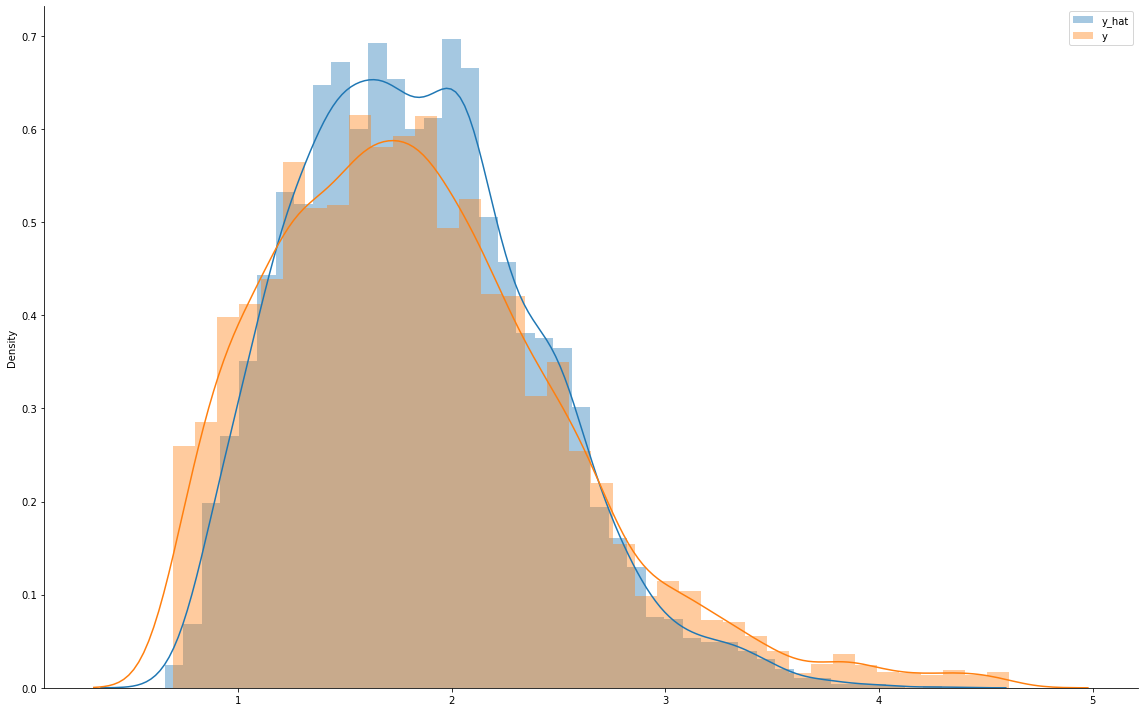

In [186]:
sns.distplot(y_pred_xgb, label='y_hat')
sns.distplot(Y_Te, label='y')
plt.legend()
sns.despine()
plt.tight_layout();

In [187]:

wait_sec_train = (np.expm1(Y_Tr)*60).round()
np.quantile(wait_sec_train, [0, 0.05, 0.5, 0.95, 0.99])

array([  60.  ,   84.  ,  291.  , 1257.85, 2972.88])

In [188]:
wait_sec_true = (np.expm1(Y_Te)*60).round()
wait_sec_predicted = (np.expm1(y_pred_xgb)*60).round()


In [189]:
wait_sec_predicted

array([401., 112., 287., ..., 275., 208., 295.], dtype=float32)

In [190]:
wait_sec_true = np.array(wait_sec_true).T[0]
residual = wait_sec_predicted - wait_sec_true.T
wait_sec_true

array([615., 115., 257., ..., 307., 276., 407.])

In [191]:
residual

array([-214.,   -3.,   30., ...,  -32.,  -68., -112.])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


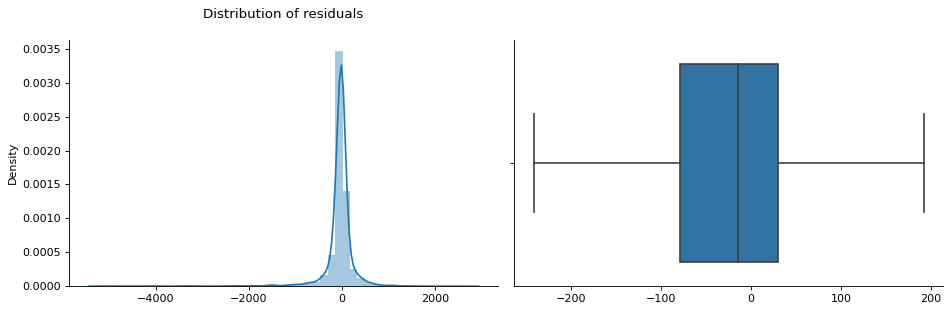

In [192]:
fig = plt.figure(num=None, figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
ax1 = sns.distplot(residual)
ax1.set_title('Distribution of residuals\n')
ax1.set_xlabel('')

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(residual, showfliers=False)
ax2.set_xlabel('')

sns.despine()
plt.tight_layout()

In [193]:
print("Mean absolute error:", np.abs(residual).mean())

Mean absolute error: 161.8057489733976


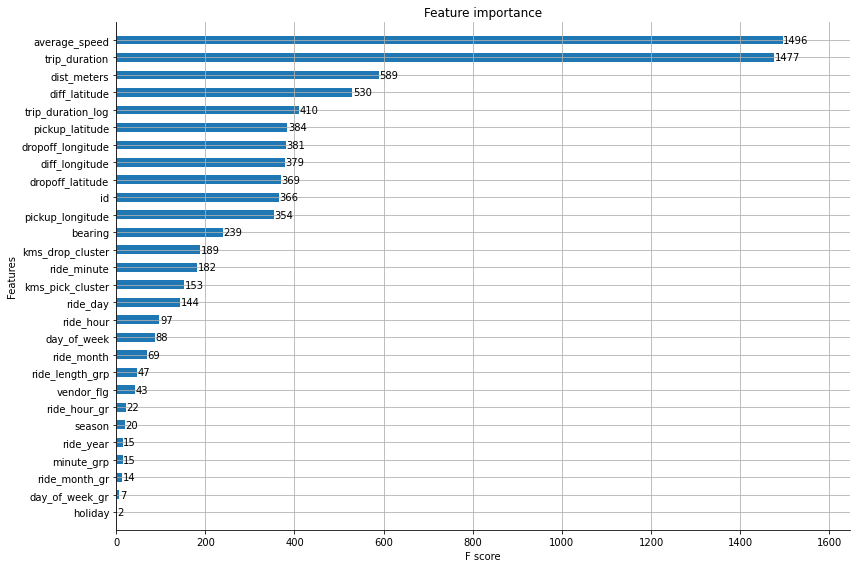

In [194]:
# feature importance
fig =  plt.figure(figsize = (12,8))
axes = fig.add_subplot(111)
xgb.plot_importance(model2,ax = axes,height =0.5)
sns.despine()
plt.tight_layout()

In [195]:
featuresImp = model2.get_score(importance_type='gain')
print(featuresImp)

{'trip_duration': 42.99433649100198, 'average_speed': 9.52699288103477, 'dist_meters': 8.172247993466891, 'ride_length_grp': 20.232283124574472, 'pickup_longitude': 2.7940298204661014, 'diff_latitude': 3.8335146422433954, 'kms_pick_cluster': 2.8450367973006534, 'trip_duration_log': 22.307664852736615, 'pickup_latitude': 2.9131778440651015, 'dropoff_longitude': 2.8572807133622056, 'day_of_week': 3.822737389545455, 'diff_longitude': 3.0126085817651678, 'dropoff_latitude': 2.9021421854905154, 'ride_day': 2.791104899770834, 'ride_hour': 2.770330327432989, 'ride_month': 2.905262675463767, 'day_of_week_gr': 3.5686331568571426, 'id': 2.359685742169399, 'kms_drop_cluster': 2.2728051743756628, 'season': 2.93781966555, 'bearing': 3.011071145543935, 'vendor_flg': 2.539849973255813, 'holiday': 1.52746272, 'minute_grp': 1.9054919052000001, 'ride_minute': 2.6245340395384624, 'ride_hour_gr': 2.1025531782727276, 'ride_month_gr': 2.6059676757142856, 'ride_year': 1.4979348616000001}


Elastic Net Model

In [196]:
grid_search = GridSearchCV( 
                              estimator= ElasticNet(),
                              param_grid={
                              'alpha':[0.001,0.003, 0.01, 0.03,0.05,0.08, 0.1, 0.12, 0.15, 0.17, 0.2, 0.21, 0.22, 0.23, 02.24, 0.25],
                              'l1_ratio': [0.1, 0.25, 0.2, 0.25, 0.3,0.35,0.4,0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.80, 0.85, 0.90]
                          },
          scoring="neg_mean_squared_error",  
          cv=KFold(n_splits=3,shuffle=True,random_state=42))   
        
grid_search.fit(X_Tr, Y_Tr)
CVed_model = grid_search.best_estimator_
print(grid_search.best_params_)

{'alpha': 0.001, 'l1_ratio': 0.1}


In [197]:
y_tr_pred_EN = CVed_model.predict(X_Tr)
rmse = np.sqrt(((y_tr_pred_EN - Y_Tr.values.ravel())**2).mean())
print("The train error is: ",rmse)

y_pred_EN = CVed_model.predict(X_Te)
rmse = np.sqrt(((y_pred_EN - Y_Te.values.ravel())**2).mean())
print("The train error is: ",rmse)

# The performance of the Elastic Net is slightly worse than xgboost while using RMSE as comparison

The train error is:  0.4376124227076255
The train error is:  0.4557325770659026


In [198]:
y_tr_pred_EN = CVed_model.predict(X_Tr)
mae = np.abs((y_tr_pred_EN - Y_Tr.values.ravel()))
print("The train error is: ",mae.mean())

y_pred_EN = CVed_model.predict(X_Te)
mae = np.abs((Y_Te.values.ravel() - y_pred_EN))
print("The test error is: ",mae.mean())

The train error is:  0.29332830649233826
The test error is:  0.30217840731079937


In [199]:
y_pred = y_pred_xgb*0.75 + 0.25*y_pred_EN
rmse = np.sqrt(((y_pred - Y_Te.values.ravel())**2).mean())
print("The test error is: ",rmse)

The test error is:  0.4124507182674139


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


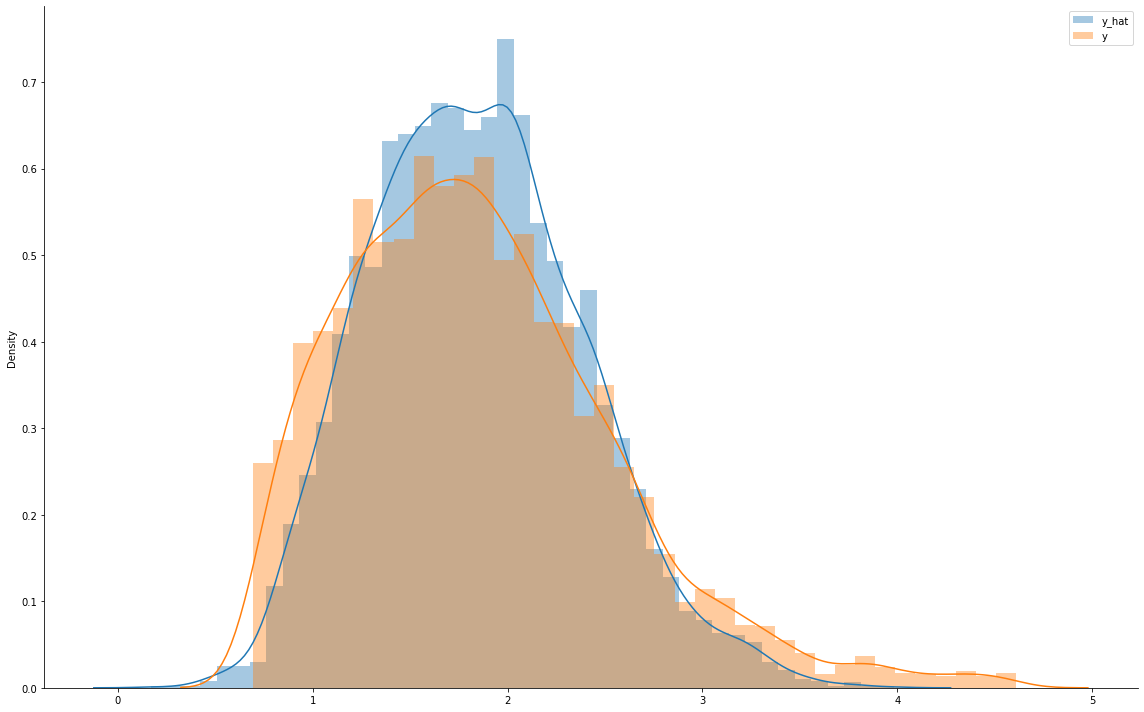

In [200]:
sns.distplot(y_pred, label='y_hat')
sns.distplot(Y_Te, label='y')
plt.legend()
sns.despine()
plt.tight_layout();

# **Scenario 1**

# **Split Data** Ref 4

In [70]:
train_dataset = uio.sample(frac=0.8, random_state=0)
test_dataset = uio.drop(train_dataset.index)

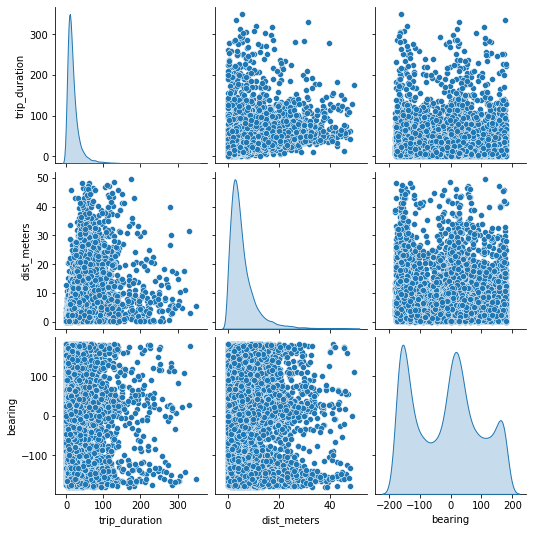

In [71]:
sns.pairplot(train_dataset[['trip_duration', 'dist_meters', 'bearing']], diag_kind='kde')

In [72]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pickup_longitude,22418.0,-78.491660,0.034024,-79.933200,-78.505500,-78.489800,-78.475400,-78.133000
pickup_latitude,22418.0,-0.188090,0.066154,-2.875800,-0.216600,-0.181900,-0.149800,0.866400
dropoff_longitude,22418.0,-78.492043,0.034436,-79.933100,-78.504800,-78.489700,-78.477225,-78.133200
dropoff_latitude,22418.0,-0.189722,0.067629,-2.875500,-0.218500,-0.185500,-0.151200,0.866800
trip_duration,22418.0,20.754557,25.668036,0.500000,8.166667,13.950000,23.683333,349.683333
dist_meters,22418.0,5.654178,5.586379,0.020000,2.239250,4.091000,7.103500,49.581000
wait_sec,22418.0,6.452047,9.082914,0.000000,1.800000,3.866667,7.500000,99.933333
ride_length_grp,22418.0,1.660987,1.111797,1.000000,1.000000,1.000000,2.000000,10.000000
ride_month,22418.0,6.534347,3.374725,1.000000,4.000000,7.000000,9.000000,12.000000
ride_year,22418.0,2016.548934,0.497611,2016.000000,2016.000000,2017.000000,2017.000000,2017.000000


In [73]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('trip_duration')
test_labels = test_features.pop('trip_duration')

In [75]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
pickup_longitude,-78.491660,0.034024
pickup_latitude,-0.188090,0.066154
dropoff_longitude,-78.492043,0.034436
dropoff_latitude,-0.189722,0.067629
trip_duration,20.754557,25.668036
dist_meters,5.654178,5.586379
wait_sec,6.452047,9.082914
ride_length_grp,1.660987,1.111797
ride_month,6.534347,3.374725
ride_year,2016.548934,0.497611


In [76]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [77]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[-7.8491592e+01 -1.8809007e-01 -7.8492012e+01 -1.8972142e-01
   5.6541772e+00  6.4520411e+00  1.6609840e+00  6.5343437e+00
   2.0165483e+03  1.5879379e+01  6.9583378e+00  2.9139713e+01
   2.7126415e+00  3.8785788e-01  9.8608214e-01  2.4315283e+00
  -3.8360723e-04 -1.6320312e-03  2.1723617e-02  7.6661658e-01
   7.3936141e-01 -1.5027091e+01]]


In [78]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ -78.5    -0.16  -78.49   -0.21    8.38    9.27    2.      5.   2017.
    16.      9.     34.      1.      0.      1.      3.      0.     -0.05
     0.      0.      0.    178.34]]

Normalized: [[-0.14  0.38 -0.08 -0.31  0.49  0.31  0.3  -0.45  0.91  0.01  0.69  0.28
  -0.92 -0.8   0.12  0.51  0.09 -1.25 -0.15 -0.9  -0.87  1.79]]


# **Regression** Ref 4.1

In [79]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.predict(train_features[:10])

linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(22, 1) dtype=float32, numpy=
array([[-0.245314  ],
       [-0.24459639],
       [-0.4846164 ],
       [-0.14815015],
       [-0.441213  ],
       [-0.43836036],
       [ 0.12740064],
       [ 0.40163028],
       [ 0.08355761],
       [-0.31133127],
       [ 0.41813177],
       [-0.44077146],
       [-0.18669772],
       [-0.46104428],
       [ 0.38001722],
       [-0.34924403],
       [ 0.4512638 ],
       [ 0.30696946],
       [ 0.48713577],
       [-0.34459692],
       [-0.04833728],
       [ 0.4518069 ]], dtype=float32)>

In [80]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [81]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 1min 31s, sys: 6.85 s, total: 1min 38s
Wall time: 1min 22s


In [82]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [trip_duration]')
  plt.legend()
  plt.grid(True)

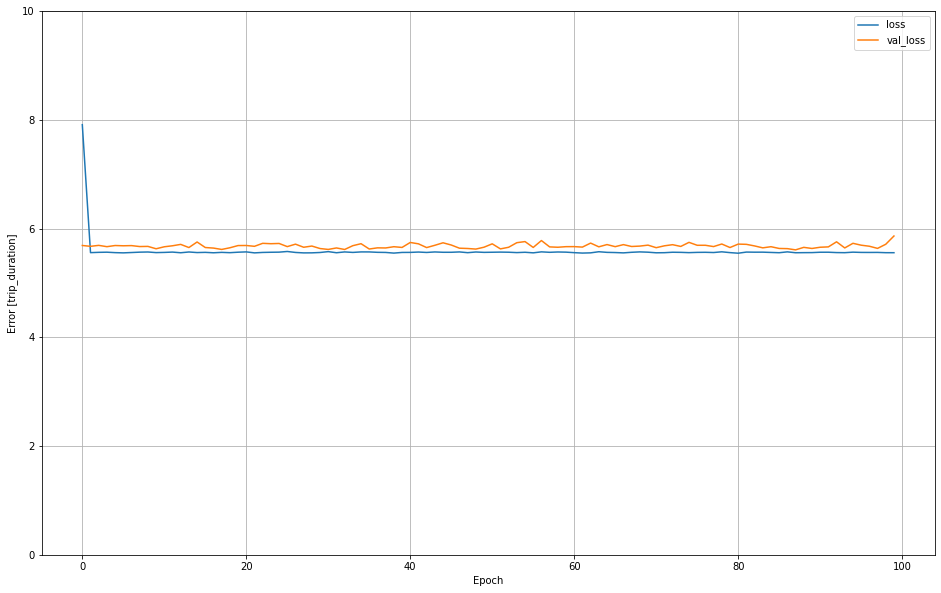

In [83]:
plot_loss(history)

In [84]:
test_results = {}

In [85]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# **Regression** Ref 4.2

In [86]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [87]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 22)               45        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 64)                1472      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,742
Trainable params: 5,697
Non-trainable params: 45
_________________________________________________________________


In [88]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    #verbose=0, 
    epochs=100)

Epoch 1/100
561/561 [==============================] - 2s 3ms/step - loss: 8.2200 - val_loss: 6.0908
Epoch 2/100
561/561 [==============================] - 1s 3ms/step - loss: 5.7648 - val_loss: 5.7219
Epoch 3/100
561/561 [==============================] - 1s 2ms/step - loss: 5.5199 - val_loss: 5.5969
Epoch 4/100
561/561 [==============================] - 1s 2ms/step - loss: 5.4067 - val_loss: 5.5305
Epoch 5/100
561/561 [==============================] - 1s 2ms/step - loss: 5.3520 - val_loss: 5.4822
Epoch 6/100
561/561 [==============================] - 1s 2ms/step - loss: 5.3244 - val_loss: 5.5023
Epoch 7/100
561/561 [==============================] - 1s 2ms/step - loss: 5.3034 - val_loss: 5.4305
Epoch 8/100
561/561 [==============================] - 1s 2ms/step - loss: 5.2811 - val_loss: 5.4417
Epoch 9/100
561/561 [==============================] - 2s 3ms/step - loss: 5.2664 - val_loss: 5.4360
Epoch 10/100
561/561 [==============================] - 3s 5ms/step - loss: 5.2653 - val_lo

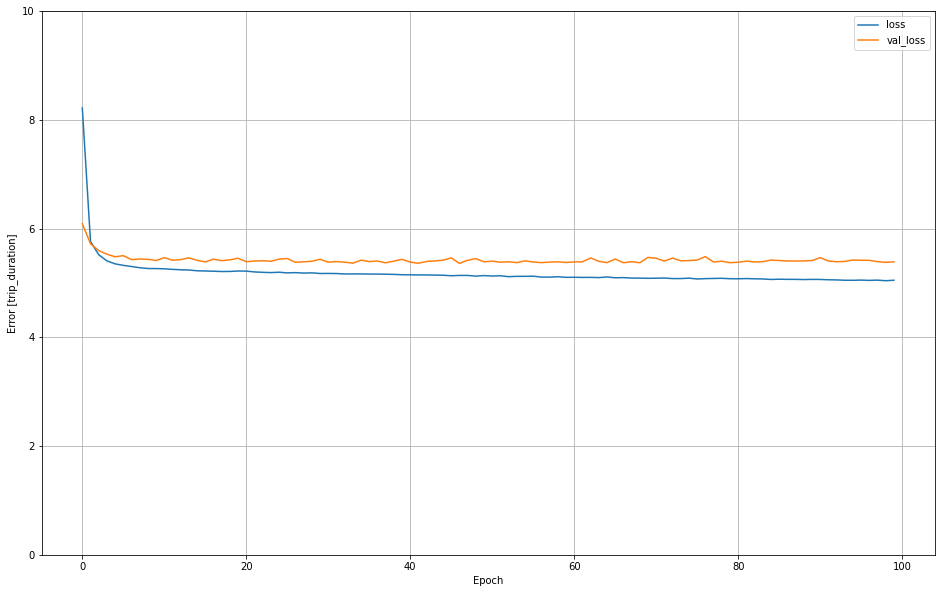

In [89]:
plot_loss(history)

In [90]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [91]:
pd.DataFrame(test_results, index=['Mean absolute error [trip_duration]']).T

,Mean absolute error [trip_duration]
linear_model,5.801003
dnn_model,5.303343


# **Make Prediction** Ref 4

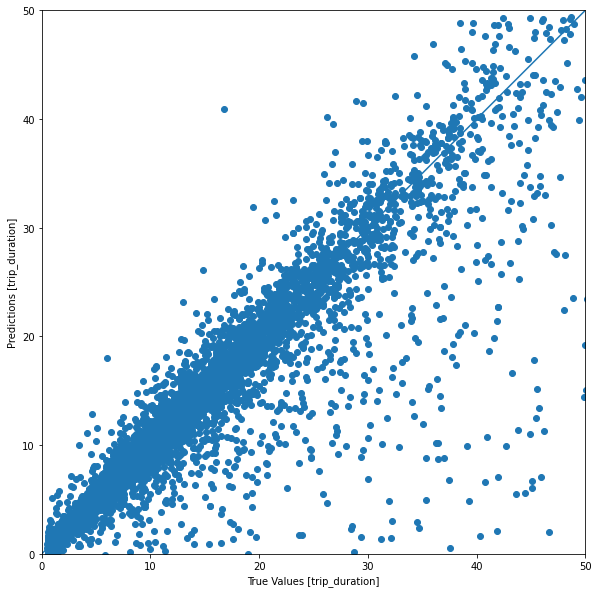

In [93]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [trip_duration]')
plt.ylabel('Predictions [trip_duration]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

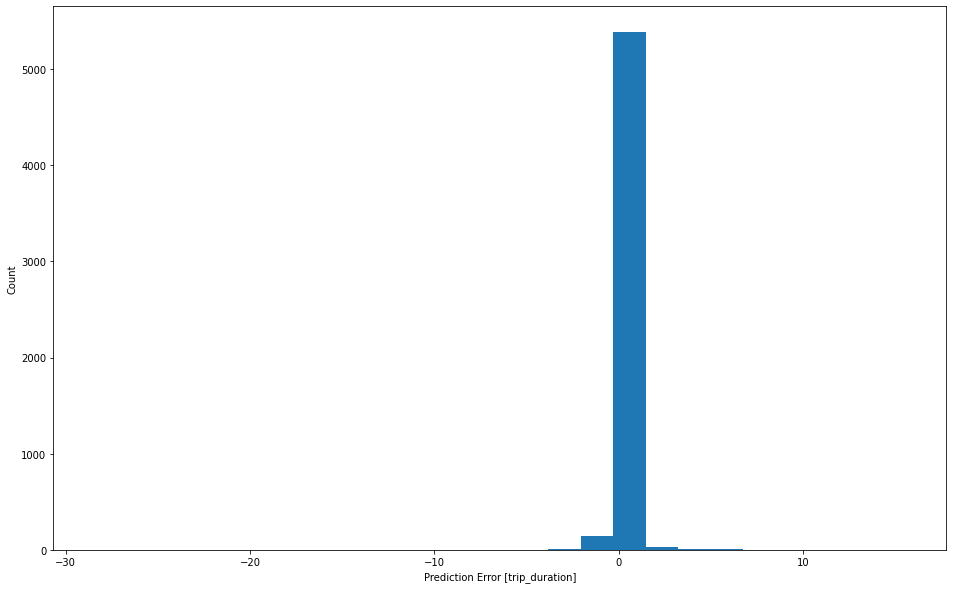

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [trip_duration]')
_ = plt.ylabel('Count')

# **Scenario 2**

# **Prediction** Ref 4.2

In [94]:
dist_meters = np.array(train_features['dist_meters'])
dist_meters_normalizer = layers.Normalization(input_shape=[1,], axis=None)
dist_meters_normalizer.adapt(dist_meters)

In [95]:
dnn_dist_meters_model = build_and_compile_model(dist_meters_normalizer)
dnn_dist_meters_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                128       
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [96]:
%%time
history = dnn_dist_meters_model.fit(
    train_features['dist_meters'],
    train_labels,
    validation_split=0.2,
    #verbose=0, 
    epochs=100)

CPU times: user 2min 4s, sys: 8.54 s, total: 2min 13s
Wall time: 2min 22s


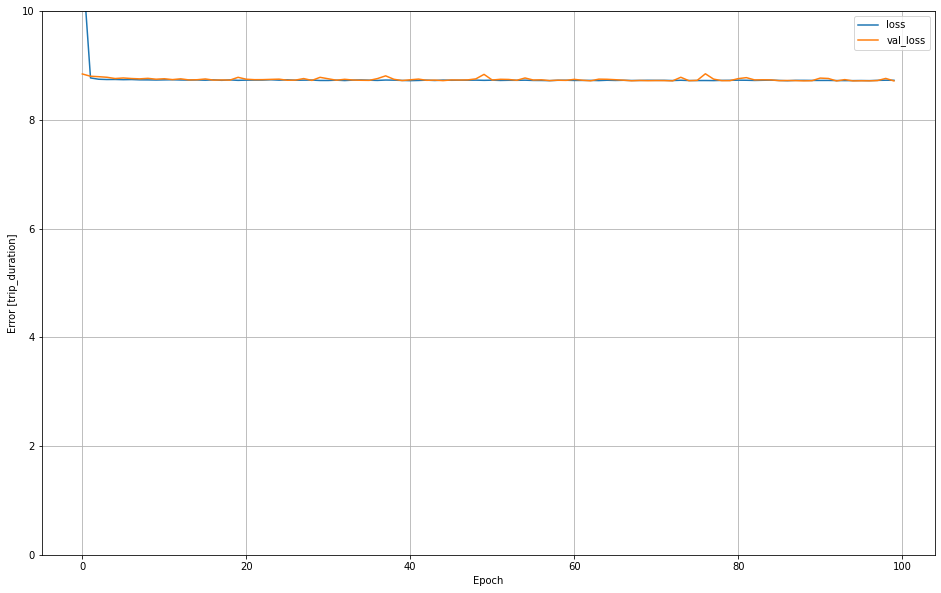

In [97]:
plot_loss(history)

In [98]:
x = tf.linspace(0.0, 250, 251)
y = dnn_dist_meters_model.predict(x)

In [99]:
test_results['dnn_dist_meters_model'] = dnn_dist_meters_model.evaluate(
    test_features['dist_meters'], test_labels,
    verbose=0)